# ASME Autodesk Hackathon 2023

### Notebook 2: Feature engineering and dataset investigation

- __Data Loading__: Start by loading and reading the provided JSON file to understand the data structure and contents. This includes:
    - Read the name of each body in the train assemblies, and also expand to read other information about the bodies, like their volume or corresponding image/STEP files
    - Read the ground truth material of each body
- __Feature Engineering__: make full use of different features. The JSON file contains nested structures. We need to extract relevant features like volume, body name, area, physical_properties, etc. for each part.
- __Data Transformation__: Convert the extracted features into a format suitable for feeding into a machine learning model, i.e., a tabular form where each row represents a part and columns represent the feature.
- Create a __train/validation splits__.

## Setup

In [2]:
import os
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
import backoff
import time
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,random_projection)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [3]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'features_v4')
Feature_PATH = os.path.join(PROJECT_ROOT_DIR, "feature_extraction")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(Feature_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Read file and get the target output (material category)

In [4]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [5]:
def id2name(id):
    id = id.lower()
    # id = id.rstrip()
    if id == 'metal_non-ferrous':
        return 'non-ferrous metal'
    elif id == 'metal_ferrous':
        return 'ferrous metal'
    elif id == 'metal_ferrous_steel':
        return 'steel'
    elif id == 'metal_aluminum':
        return 'aluminum'
    elif id in ['other', 'wood', 'plastic']:
        return id
    else:
        raise f"Non-default id! {id}"
        # return 'other'

In [6]:
def plot_data_distribution(data, variable, title, filename, figure_size = ((7,6))):
    # Initialize the plot
    plt.figure(figsize = figure_size)
    
    # Create the countplot
    ax = sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel(variable, fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()

def plot_multi_label_distribution(data, variable, title, filename, figure_size = ((7,6))): 
    # Split the multi-label feature into individual labels
    all_labels = data[variable].str.split(',', expand=True).stack().reset_index(drop=True)
    
    # Initialize the plot
    plt.figure(figsize = figure_size)
    
    # Create the countplot for individual labels
    ax = sns.countplot(x=all_labels, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, order=all_labels.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel(variable, fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()


def plot_multi_label_distribution_selected(data, variable, title, filename, figure_size=(7,6), top_n=5): 
    # Split the multi-label feature into individual labels
    all_labels = data[variable].str.split(',', expand=True).stack().reset_index(drop=True)
    
    # Get the top_n labels based on their counts
    top_labels = all_labels.value_counts().index[:top_n]
    
    # Initialize the plot
    plt.figure(figsize=figure_size)
    
    # Create the countplot for individual labels
    ax = sns.countplot(x=all_labels, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, 
                       order=top_labels)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel(variable, fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()
# Example usage (you can run this in your local environment):
# plot_multi_label_distribution(consolidated_dataset, 'assembly_industries', 
    # 'Distribution of Fusion Gallery Dataset per Industry', 'industries_distribution')

In [7]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

## Read the material and names of bodies in assemlies
Loop through each of the 'assembly.json' files in the dataset, and read the name and material_categeory of each body in the assembly.
As some bodies do not have a custom name, but the default name 'body#', we will filter those out as our LLM baseline cannot predict those.

### Inspect an individual json file

In [8]:
# Load and inspect the contents of the provided assembly.json file again
with open("D:\Dataset\\ASME-Hackathon-2023-Autodesk\\train_data\\Fusion360GalleryDataset_23hackathon_train\\7780_6c885e81\\assembly.json", "r") as file:
    assembly_data = json.load(file)

In [9]:
# Display some key-value pairs from the assembly_data dictionary for inspection
dict(list(assembly_data.items())[:2])  # Display the first two entries for brevity

{'tree': {'root': {'e3bf35b5-0608-11ec-b277-02052889e3af': {},
   'e3bf83d8-0608-11ec-969c-02052889e3af': {},
   'e3bfaae2-0608-11ec-9e7f-02052889e3af': {},
   'e3bfd1f0-0608-11ec-878f-02052889e3af': {},
   'e3bff8fe-0608-11ec-a2e3-02052889e3af': {},
   'e3c02012-0608-11ec-8241-02052889e3af': {}}},
 'root': {'component': 'e3bf0ea5-0608-11ec-a392-02052889e3af'}}

In [10]:
# Display the top-level keys of the assembly_data dictionary
assembly_data.keys()

dict_keys(['tree', 'root', 'occurrences', 'components', 'bodies', 'as_built_joints', 'contacts', 'holes', 'properties'])

In [11]:
# Display a sample from the 'bodies' section for inspection
sample_body = list(assembly_data['bodies'].values())[3]
sample_body

{'name': 'Body7',
 'type': 'BRepBody',
 'png': 'e397626e-0608-11ec-a470-02052889e3af.png',
 'smt': 'e397626e-0608-11ec-a470-02052889e3af.smt',
 'step': 'e397626e-0608-11ec-a470-02052889e3af.step',
 'obj': 'e397626e-0608-11ec-a470-02052889e3af.obj',
 'physical_properties': {'center_of_mass': {'type': 'Point3D',
   'x': 0.25315821192952176,
   'y': 0.03333797923237883,
   'z': 2.7849977545097624},
  'area': 19.067095914836415,
  'volume': 1.128564254878852},
 'material_category': 'Plastic'}

In [12]:
# Checking the type and structure of 'bodies' and 'properties'
bodies_type = type(assembly_data['bodies'])
properties_type = type(assembly_data['properties'])

# If they are dictionaries, let's see some of their keys
bodies_keys = list(assembly_data['bodies'].keys()) if isinstance(assembly_data['bodies'], dict) else None
properties_keys = list(assembly_data['properties'].keys()) if isinstance(assembly_data['properties'], dict) else None

bodies_type, bodies_keys, properties_type, properties_keys

(dict,
 ['e334f792-0608-11ec-8db2-02052889e3af',
  'e35af5a4-0608-11ec-b52a-02052889e3af',
  'e363cf40-0608-11ec-881d-02052889e3af',
  'e397626e-0608-11ec-a470-02052889e3af',
  'e398c200-0608-11ec-914e-02052889e3af',
  'e399105e-0608-11ec-be9b-02052889e3af'],
 dict,
 ['name',
  'bounding_box',
  'vertex_count',
  'edge_count',
  'face_count',
  'loop_count',
  'shell_count',
  'body_count',
  'area',
  'volume',
  'density',
  'mass',
  'center_of_mass',
  'principal_axes',
  'xyz_moments_of_inertia',
  'surface_types',
  'vertex_valence',
  'design_type',
  'likes_count',
  'comments_count',
  'views_count',
  'products',
  'categories',
  'industries'])

## Feature extraction for a single assembly

### V1: Basic feature extractions: from 'properties' and 'bodies'

- UUID: A unique identifier for each body.
- Name: The name of the body.
- Type: The type of the body (e.g., BRepBody).
- **COM Distance**: Euclidean distance between the center of mass of the body and the center of mass of the assembly.
- **Center of Mass Coordinates**: x, y, and z coordinates of the body's center of mass.
- **Body Area & Volume**: Surface area and volume of the body.
- Material Category: The material category of the body.
- **Volume Fraction**: Fraction of the body's volume to the entire assembly's volume.
- **Assembly properties**: Various properties related to the assembly, such as bounding box dimensions, moments of inertia, and derived features like aspect ratios.

In [13]:
def extract_features_v1(data):
    # Extracting global features from 'properties'
    global_properties = data['properties']
    bounding_box = global_properties.get('bounding_box', {})
    max_point = bounding_box.get('max_point', {})
    min_point = bounding_box.get('min_point', {})
    
    # Bounding box dimensions
    x_dim = max_point.get('x', 0) - min_point.get('x', 0)
    y_dim = max_point.get('y', 0) - min_point.get('y', 0)
    z_dim = max_point.get('z', 0) - min_point.get('z', 0)
    
    # Derived features
    aspect_ratio_xy = x_dim / (y_dim + 1e-10)
    aspect_ratio_xz = x_dim / (z_dim + 1e-10)
    aspect_ratio_yz = y_dim / (z_dim + 1e-10)
    
    moments_of_inertia = global_properties.get('xyz_moments_of_inertia', {})
    
    # Global features
    global_features = {
        'bounding_box_max_x' : max_point.get('x'),
        'bounding_box_max_y' : max_point.get('y'),
        'bounding_box_max_z' : max_point.get('z'),
        'bounding_box_min_x' : min_point.get('x'),
        'bounding_box_min_y' : min_point.get('y'),
        'bounding_box_min_z' : min_point.get('z'),
        'vertex_count' : global_properties.get("vertex_count"),
        'edge_count': global_properties.get("edge_count"),
        'face_count': global_properties.get("face_count"),
        'loop_count': global_properties.get("loop_count"),
        'shell_count': global_properties.get("shell_count"),
        'body_count': global_properties.get("body_count"),
        'assembly_area': global_properties.get('area'),
        'assembly_volume': global_properties.get('volume'),
        'assembly_mass': global_properties.get('mass'),
        'assembly_density': global_properties.get('density'),
        'assembly_center_of_mass_x' : global_properties.get('center_of_mass', {}).get('x'),
        'assembly_center_of_mass_y' : global_properties.get('center_of_mass', {}).get('y'),
        'assembly_center_of_mass_z' : global_properties.get('center_of_mass', {}).get('z'),
        'assembly_likes_count' : global_properties.get('likes_count'),
        'assembly_comments_count' : global_properties.get('comments_count'),  
        'assembly_views_count' : global_properties.get('views_count'),
        'assembly_design_type': global_properties.get('design_type'),
        'assembly_categories': ",".join(global_properties.get('categories', [])),
        'assembly_industries': ",".join(global_properties.get('industries', [])),
        'bounding_box_x_dim': x_dim,
        'bounding_box_y_dim': y_dim,
        'bounding_box_z_dim': z_dim,
        'aspect_ratio_xy': aspect_ratio_xy,
        'aspect_ratio_xz': aspect_ratio_xz,
        'aspect_ratio_yz': aspect_ratio_yz,
        'moment_of_inertia_xx': moments_of_inertia.get('xx'),
        'moment_of_inertia_yy': moments_of_inertia.get('yy'),
        'moment_of_inertia_zz': moments_of_inertia.get('zz'),
        'moment_of_inertia_xy': moments_of_inertia.get('xy'),
        'moment_of_inertia_yz': moments_of_inertia.get('yz'),
        'moment_of_inertia_xz': moments_of_inertia.get('xz'),
        'vertex_to_edge_ratio': global_properties.get("vertex_count") / (global_properties.get("edge_count") + 1e-10),
        'face_to_loop_ratio': global_properties.get("face_count") / (global_properties.get("loop_count") + 1e-10)
    }
    
    # Extracting features from 'bodies'
    bodies_data = data['bodies']
    features_list = []
    for uuid, body_info in bodies_data.items():
        features = {}
        features['uuid'] = uuid
        features['name'] = body_info['name']
        features['type'] = body_info['type']
        
        # Extracting physical properties
        physical_properties = body_info.get('physical_properties', {})
        com_body_x = physical_properties.get('center_of_mass', {}).get('x')
        com_body_y = physical_properties.get('center_of_mass', {}).get('y')
        com_body_z = physical_properties.get('center_of_mass', {}).get('z')
        
        # Compute Euclidean distance between body's COM and assembly's COM
        com_assembly_x = global_features['assembly_center_of_mass_x']
        com_assembly_y = global_features['assembly_center_of_mass_y']
        com_assembly_z = global_features['assembly_center_of_mass_z']
        
        features['com_distance'] = np.sqrt((com_body_x - com_assembly_x)**2 + 
                                           (com_body_y - com_assembly_y)**2 + 
                                           (com_body_z - com_assembly_z)**2)
        
        features['center_of_mass_x'] = com_body_x
        features['center_of_mass_y'] = com_body_y
        features['center_of_mass_z'] = com_body_z
        features['body_area'] = physical_properties.get('area')
        features['body_volume'] = physical_properties.get('volume')
        features['material_category'] = body_info.get('material_category')
        
        # Calculate the volume fraction
        features['volume_fraction'] = features['body_volume'] / (global_features['assembly_volume'] + 1e-10)
        
        # Combining local and global features
        features.update(global_features)
        
        features_list.append(features)
    
    # Convert to a DataFrame
    df = pd.DataFrame(features_list)
    return df

# Extract enhanced features from the data
enhanced_features_df_updated = extract_features_v1(assembly_data)
enhanced_features_df_updated.head()

uuid   name      type  com_distance  \
0  e334f792-0608-11ec-8db2-02052889e3af  Body1  BRepBody      0.736871   
1  e35af5a4-0608-11ec-b52a-02052889e3af  Body1  BRepBody      5.225931   
2  e363cf40-0608-11ec-881d-02052889e3af  Body1  BRepBody      3.729550   
3  e397626e-0608-11ec-a470-02052889e3af  Body7  BRepBody      5.288061   
4  e398c200-0608-11ec-914e-02052889e3af  Body1  BRepBody      6.326714   

   center_of_mass_x  center_of_mass_y  center_of_mass_z   body_area  \
0         -0.687616         -0.943699         -2.616353  127.290229   
1          0.000004          1.384977          2.279890   14.215417   
2         -0.000012         -1.983619         -5.985433   95.038657   
3          0.253158          0.033338          2.784998   19.067096   
4          0.000000         -0.051908          3.855522   16.260164   

   body_volume material_category  ...  aspect_ratio_xz  aspect_ratio_yz  \
0     6.192045     Metal_Ferrous  ...         0.162329         0.384771   
1     1.220741           Plastic  ...         0.162329         0.384771   
2     8.699074           Plastic  ...         0.162329         0.384771   
3     1.128564           Plastic  ...         0.162329         0.384771   
4     0.446419     Metal_Ferrous  ...         0.162329         0.384771   

   moment_of_inertia_xx  moment_of_inertia_yy  moment_of_inertia_zz  \
0              3.078583               2.76705              0.436197   
1              3.078583               2.76705              0.436197   
2              3.078583               2.76705              0.436197   
3              3.078583               2.76705              0.436197   
4              3.078583               2.76705              0.436197   

   moment_of_inertia_xy  moment_of_inertia_yz  moment_of_inertia_xz  \
0             -0.000102             -0.772865             -0.002527   
1             -0.000102             -0.772865             -0.002527   
2             -0.000102             -0.772865             -0.002527   
3             -0.000102             -0.772865             -0.002527   
4             -0.000102             -0.772865             -0.002527   

   vertex_to_edge_ratio  face_to_loop_ratio  
0              0.654088            0.946524  
1              0.654088            0.946524  
2              0.654088            0.946524  
3              0.654088            0.946524  
4              0.654088            0.946524  

[5 rows x 50 columns]

### V2: Adding features from holes, trees, and tree depth

- **surface_types**: the type of surface (surface_type) and the number of faces of that type (face_count).- __vertex_valene__:  the valence (valence) and the count of vertices with that valence (count).

In [14]:
def extract_features_v2(data):
    # Start with the basic v1 function
    df = extract_features_v1(data)
    
    # Extracting features related to 'surface_types' and 'vertex_valence'
    properties_data = data.get('properties', {})
    surface_types = properties_data.get('surface_types', [])
    
    # Pre-defined possible surface types
    possible_surface_types = [
        'ConeSurfaceType',
        'CylinderSurfaceType',
        'EllipticalConeSurfaceType',
        'EllipticalCylinderSurfaceType',
        'NurbsSurfaceType',
        'PlaneSurfaceType',
        'SphereSurfaceType',
        'TorusSurfaceType'
    ]
    
    for surface_type in possible_surface_types:
        column_name = f"surface_type_{surface_type}"
        df[column_name] = surface_types.count(surface_type)
    
    # Handling vertex_valence
    vertex_valence_data = properties_data.get('vertex_valence', [])
    vertex_valence_dict = {item['valence']: item['count'] for item in vertex_valence_data}
    
    # Segmented representation for vertex_valence
    df['vertex_valence_1_2'] = sum([vertex_valence_dict.get(i, 0) for i in range(1, 2)])
    df['vertex_valence_2_5'] = sum([vertex_valence_dict.get(i, 0) for i in range(2, 5)])
    df['vertex_valence_5_10'] = sum([vertex_valence_dict.get(i, 0) for i in range(5, 11)])
    df['vertex_valence_above_10'] = sum([val for key, val in vertex_valence_dict.items() if key > 10])
    
    return df

# Apply the improved v2 function on the sample data
enhanced_features_v2_df = extract_features_v2(assembly_data)
enhanced_features_v2_df.head()

uuid   name      type  com_distance  \
0  e334f792-0608-11ec-8db2-02052889e3af  Body1  BRepBody      0.736871   
1  e35af5a4-0608-11ec-b52a-02052889e3af  Body1  BRepBody      5.225931   
2  e363cf40-0608-11ec-881d-02052889e3af  Body1  BRepBody      3.729550   
3  e397626e-0608-11ec-a470-02052889e3af  Body7  BRepBody      5.288061   
4  e398c200-0608-11ec-914e-02052889e3af  Body1  BRepBody      6.326714   

   center_of_mass_x  center_of_mass_y  center_of_mass_z   body_area  \
0         -0.687616         -0.943699         -2.616353  127.290229   
1          0.000004          1.384977          2.279890   14.215417   
2         -0.000012         -1.983619         -5.985433   95.038657   
3          0.253158          0.033338          2.784998   19.067096   
4          0.000000         -0.051908          3.855522   16.260164   

   body_volume material_category  ...  surface_type_EllipticalConeSurfaceType  \
0     6.192045     Metal_Ferrous  ...                                       0   
1     1.220741           Plastic  ...                                       0   
2     8.699074           Plastic  ...                                       0   
3     1.128564           Plastic  ...                                       0   
4     0.446419     Metal_Ferrous  ...                                       0   

   surface_type_EllipticalCylinderSurfaceType  surface_type_NurbsSurfaceType  \
0                                           0                              0   
1                                           0                              0   
2                                           0                              0   
3                                           0                              0   
4                                           0                              0   

   surface_type_PlaneSurfaceType  surface_type_SphereSurfaceType  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   surface_type_TorusSurfaceType  vertex_valence_1_2  vertex_valence_2_5  \
0                              0                  10                 614   
1                              0                  10                 614   
2                              0                  10                 614   
3                              0                  10                 614   
4                              0                  10                 614   

   vertex_valence_5_10  vertex_valence_above_10  
0                    0                        0  
1                    0                        0  
2                    0                        0  
3                    0                        0  
4                    0                        0  

[5 rows x 62 columns]

### V3: Adding features from holes, trees, and tree depth

- __Tree Depth__: Maximum depth of the tree.
- __Occurrences__: Total number of occurrences and unique component occurrences.
- __Holes__: Total number of holes, average diameter of holes. distrubution of the type of the holes types. hole length, Distribution of holes across bodies

In [15]:
def traverse_tree(tree, depth=0):
    """Helper function to recursively traverse the tree and compute its depth."""
    if not tree:
        return depth
    children_depths = [traverse_tree(child, depth + 1) for _, child in tree.items()]
    return max(children_depths)

In [16]:
def extract_features_v3(data):
    # Start with the basic v2 function
    df = extract_features_v2(data)
    
    # Extracting features from 'tree'
    tree_data = data.get('tree', {})
    tree_depth = traverse_tree(tree_data)
    df['tree_depth'] = tree_depth

    # Extracting features from 'occurrences'
    occurrences_data = data.get('occurrences', {})
    df['occurrences_count'] = len(occurrences_data)
    unique_component_occurrences = len(set([occ.get('component') for occ in occurrences_data.values()]))
    df['unique_component_occurrences'] = unique_component_occurrences

    # Extracting features from 'holes'
    holes_data = data.get('holes', [])

    # Initialize columns
    df['num_holes'] = 0
    df['avg_hole_diameter'] = 0
    df['avg_hole_length'] = 0
    all_hole_types = [
        'RoundHoleWithBlindBottom', 'RoundBlindHoleWithConicalBottom', 'RoundBlindHoleWithSphericalBottom',
        'RoundBlindHoleWithTaperedBottom', 'RoundHoleWithThroughBottom', 'TaperedRoundHoleWithBlindBottom',
        'TaperedRoundHoleWithThroughBottom', 'CounterboreBlindHole', 'CounterboreBlindHoleWithConicalBottom',
        'CounterboreBlindHoleWithSphericalBottom', 'CounterboreBlindHoleWithTaperedBottom', 'CounterboreThroughHole',
        'TaperedCounterboreBlindHole', 'TaperedCounterboreHoleWithThroughBottom', 'CountersunkHoleWithBlindBottom',
        'CountersunkBlindHoleWithConicalBottom', 'CountersunkBlindHoleWithSphericalBottom',
        'CountersunkBlindHoleWithTaperedBottom', 'CountersunkHoleWithThroughBottom', 'CountersunkCounterboreBlindHole',
        'CountersunkCounterboreBlindHoleWithConicalBottom', 'CountersunkCounterboreBlindHoleWithSphericalBottom',
        'CountersunkCounterboreBlindHoleWithTaperedBottom', 'CountersunkCounterboreThroughHole'
    ]

    # Create a column for each hole type initialized to zero
    for hole_type in all_hole_types:
        df[f"hole_type_{hole_type}"] = 0

    # Loop over each body and extract hole data
    for idx, row in df.iterrows():
        body_uuid = row['uuid']
        associated_holes = [hole for hole in holes_data if hole.get('body') == body_uuid]
        
        # Update hole count
        df.at[idx, 'num_holes'] = len(associated_holes)

        # If there are holes associated with this body, compute the other statistics
        if associated_holes:
            # Diameter and Length
            diameters = [hole.get('diameter', 0) for hole in associated_holes]
            lengths = [hole.get('length', 0) for hole in associated_holes]
            
            df.at[idx, 'avg_hole_diameter'] = sum(diameters) / len(diameters)
            df.at[idx, 'avg_hole_length'] = sum(lengths) / len(lengths)
            
            # Hole types
            hole_types = [hole.get('type') for hole in associated_holes]
            for hole_type in set(hole_types):
                column_name = f"hole_type_{hole_type}"
                df.at[idx, column_name] = hole_types.count(hole_type)
    
    return df

# Checking the first few rows of the enhanced features extracted using our v3 function
enhanced_features_v3_df = extract_features_v3(assembly_data)
enhanced_features_v3_df.head()

uuid   name      type  com_distance  \
0  e334f792-0608-11ec-8db2-02052889e3af  Body1  BRepBody      0.736871   
1  e35af5a4-0608-11ec-b52a-02052889e3af  Body1  BRepBody      5.225931   
2  e363cf40-0608-11ec-881d-02052889e3af  Body1  BRepBody      3.729550   
3  e397626e-0608-11ec-a470-02052889e3af  Body7  BRepBody      5.288061   
4  e398c200-0608-11ec-914e-02052889e3af  Body1  BRepBody      6.326714   

   center_of_mass_x  center_of_mass_y  center_of_mass_z   body_area  \
0         -0.687616         -0.943699         -2.616353  127.290229   
1          0.000004          1.384977          2.279890   14.215417   
2         -0.000012         -1.983619         -5.985433   95.038657   
3          0.253158          0.033338          2.784998   19.067096   
4          0.000000         -0.051908          3.855522   16.260164   

   body_volume material_category  ...  \
0     6.192045     Metal_Ferrous  ...   
1     1.220741           Plastic  ...   
2     8.699074           Plastic  ...   
3     1.128564           Plastic  ...   
4     0.446419     Metal_Ferrous  ...   

   hole_type_CountersunkHoleWithBlindBottom  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   hole_type_CountersunkBlindHoleWithConicalBottom  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   hole_type_CountersunkBlindHoleWithSphericalBottom  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   hole_type_CountersunkBlindHoleWithTaperedBottom  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   hole_type_CountersunkHoleWithThroughBottom  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   hole_type_CountersunkCounterboreBlindHole  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   hole_type_CountersunkCounterboreBlindHoleWithConicalBottom  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   hole_type_CountersunkCounterboreBlindHoleWithSphericalBottom  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0              

   hole_type_CountersunkCounterboreBlindHoleWithTaperedBottom  \
0                                                  0            
1                                                  0            
2                                                  0            
3       

### V4 function: Joint
  - Number of Joints per Type: For every joint type mentioned (e.g., RigidJointType, RevoluteJointType, etc.), we can count how many of those joints are there in the assembly.
  - Is Flipped Count: Count of joints where is_flipped is True.
  - Joint Angles & Offsets: These might be interesting but could be tricky as they are properties that could vary per joint. A possible approach is to compute statistical measures like mean, min, max, and standard deviation of these values across all joints. However, it could also make the dataset high dimensional if we consider every joint's angle and offset. Compute statistical measures (mean, min, max, standard deviation) for joint angles and offsets.
  - as_built_joint
    

In [17]:
def extract_features_v4(data):
    # Start with our previously defined v3 function
    df = extract_features_v3(data)
    
    # Extract features related to 'joints' (if they exist in the data)
    joints_data = data.get('joints', {})
    
    joint_types = ['RigidJointType', 'RevoluteJointType', 'SliderJointType', 'CylindricalJointType',
                   'PinSlotJointType', 'PlanarJointType', 'BallJointType']
    
    # Initialize counters
    joint_type_counts = {joint_type: 0 for joint_type in joint_types}
    is_flipped_count = 0
    angles = []
    offsets = []
    
    if joints_data and isinstance(joints_data, dict):  # Check if joints_data is a dictionary
        for _, joint_info in joints_data.items():
            joint_type_counts[joint_info.get('joint_motion', {}).get('joint_type', 'Unknown')] += 1
            is_flipped_count += joint_info.get('is_flipped', False)

            angle_info = joint_info.get('angle', {})
            if angle_info:
                angles.append(angle_info.get('value', 0))

            offset_info = joint_info.get('offset', {})
            if offset_info:
                offsets.append(offset_info.get('value', 0))
    
    df['is_flipped_count'] = is_flipped_count
    df['avg_joint_angle'] = np.mean(angles) if angles else 0
    df['std_joint_angle'] = np.std(angles) if angles else 0
    df['min_joint_angle'] = np.min(angles) if angles else 0
    df['max_joint_angle'] = np.max(angles) if angles else 0
    df['avg_joint_offset'] = np.mean(offsets) if offsets else 0
    df['std_joint_offset'] = np.std(offsets) if offsets else 0
    df['min_joint_offset'] = np.min(offsets) if offsets else 0
    df['max_joint_offset'] = np.max(offsets) if offsets else 0
    
    # Incorporate joint type counts to the dataframe
    for joint_type, count in joint_type_counts.items():
        df[joint_type] = count
    
    # Extract features related to 'as_built_joints' (if they exist in the data)
    as_built_joints_data = data.get('as_built_joints', {})
    df['total_as_built_joints'] = len(as_built_joints_data) if isinstance(as_built_joints_data, dict) else 0
    
    return df

# Apply the new function
enhanced_features_v4_df = extract_features_v4(assembly_data)
enhanced_features_v4_df.head()

uuid   name      type  com_distance  \
0  e334f792-0608-11ec-8db2-02052889e3af  Body1  BRepBody      0.736871   
1  e35af5a4-0608-11ec-b52a-02052889e3af  Body1  BRepBody      5.225931   
2  e363cf40-0608-11ec-881d-02052889e3af  Body1  BRepBody      3.729550   
3  e397626e-0608-11ec-a470-02052889e3af  Body7  BRepBody      5.288061   
4  e398c200-0608-11ec-914e-02052889e3af  Body1  BRepBody      6.326714   

   center_of_mass_x  center_of_mass_y  center_of_mass_z   body_area  \
0         -0.687616         -0.943699         -2.616353  127.290229   
1          0.000004          1.384977          2.279890   14.215417   
2         -0.000012         -1.983619         -5.985433   95.038657   
3          0.253158          0.033338          2.784998   19.067096   
4          0.000000         -0.051908          3.855522   16.260164   

   body_volume material_category  ...  min_joint_offset  max_joint_offset  \
0     6.192045     Metal_Ferrous  ...                 0                 0   
1     1.220741           Plastic  ...                 0                 0   
2     8.699074           Plastic  ...                 0                 0   
3     1.128564           Plastic  ...                 0                 0   
4     0.446419     Metal_Ferrous  ...                 0                 0   

   RigidJointType  RevoluteJointType  SliderJointType  CylindricalJointType  \
0               0                  0                0                     0   
1               0                  0                0                     0   
2               0                  0                0                     0   
3               0                  0                0                     0   
4               0                  0                0                     0   

   PinSlotJointType  PlanarJointType  BallJointType  total_as_built_joints  
0                 0                0              0                      2  
1                 0                0              0                      2  
2                 0                0              0                      2  
3                 0                0              0                      2  
4                 0                0              0                      2  

[5 rows x 109 columns]

Components:

- Total number of components (total_components).
- Number of unique components (unique_components).

Joints:
- Total number of joints (total_joints).
- Count of rotational joints (rotational_joints).
- Count of slider joints (slider_joints).

As Built Joints:
- Total number of as-built joints (total_as_built_joints).

Contacts:
- Total number of contacts (total_contacts).

## Feature extraction pipline

In [18]:
# input_dir = r"D:\FusionGallery\Fusion360GalleryDataset_23hackathon"  
input_dir = r"D:\Dataset\ASME-Hackathon-2023-Autodesk\train_data\Fusion360GalleryDataset_23hackathon_train"

In [19]:
def process_assemblies(input_dir):
    # Retrieve all the assembly JSON files from the directory
    input_jsons = get_all_files(input_dir, "*/assembly.json")
    
    # This will store all the extracted features from all files
    all_features = []
    
    for input_json in tqdm(input_jsons):
        with open(input_json, "r", encoding="utf-8") as f:
            assembly_data = json.load(f)

        # Extract features using our function
        extracted_features = extract_features_v4(assembly_data)
        
        # # Add the assembly filename as an additional feature for traceability
        # extracted_features['assembly_filename'] = str(input_json.parts[-2])
        
        all_features.append(extracted_features)
    
    # Concatenate all features into a single DataFrame
    consolidated_df = pd.concat(all_features, ignore_index=True)
    return consolidated_df

# Modify the path according to your directory structure
input_dir = r"D:\Dataset\ASME-Hackathon-2023-Autodesk\train_data\Fusion360GalleryDataset_23hackathon_train"
# To test the function, you'd run:
consolidated_dataset = process_assemblies(input_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [02:52<00:00, 36.67it/s]


In [20]:
consolidated_dataset

uuid   name      type  com_distance  \
0       f130d4f0-054c-11ec-a094-0a2b8709b52f  Body1  BRepBody      0.042693   
1       f1314a74-054c-11ec-ac03-0a2b8709b52f  Body4  BRepBody      0.381353   
2       f131bfb6-054c-11ec-9eb4-0a2b8709b52f  Body5  BRepBody      0.774408   
3       f13234e8-054c-11ec-8b13-0a2b8709b52f  Body6  BRepBody      0.704245   
4       f13282ee-054c-11ec-aa03-0a2b8709b52f  Body7  BRepBody      0.698344   
...                                      ...    ...       ...           ...   
131243  f95a09b6-0613-11ec-b131-0226f5980261  Body1  BRepBody     16.922193   
131244  f95a5828-0613-11ec-ab9b-0226f5980261  Body1  BRepBody     16.950769   
131245  f95a7efe-0613-11ec-bc18-0226f5980261  Body2  BRepBody     16.961065   
131246  f95acd26-0613-11ec-a896-0226f5980261  Body1  BRepBody     16.952311   
131247  f95af41c-0613-11ec-8208-0226f5980261  Body2  BRepBody     16.944526   

        center_of_mass_x  center_of_mass_y  center_of_mass_z  body_area  \
0           9.170593e-16          2.846286      5.060009e-13   1.892846   
1          -2.057905e-09          2.423258     -2.936297e-02   0.659531   
2          -2.066062e-09          2.421404      6.705135e-01   0.657318   
3           9.170593e-16          2.846286      7.000000e-01   1.892846   
4           9.170593e-16          2.846286     -7.000000e-01   1.892846   
...                  ...               ...               ...        ...   
131243      6.132067e-01          0.000000     -2.670490e-11   1.729151   
131244      0.000000e+00          0.181651      1.007575e-11   0.129364   
131245     -6.182051e-17         -0.011000      8.108617e-12   0.016467   
131246      0.000000e+00          0.150000      1.045680e-11   0.109956   
131247      3.451123e-17          0.325000     -1.045678e-11   0.094248   

        body_volume    material_category  ...  min_joint_offset  \
0          0.064315              Plastic  ...               0.0   
1          0.007196  Metal_Ferrous_Steel  ...               0.0   
2          0.007167    Metal_Non-Ferrous  ...               0.0   
3          0.064315                Other  ...               0.0   
4          0.064315              Plastic  ...               0.0   
...             ...                  ...  ...               ...   
131243     0.116680  Metal_Ferrous_Steel  ...               0.0   
131244     0.002853  Metal_Ferrous_Steel  ...               0.0   
131245     0.000024  Metal_Ferrous_Steel  ...               0.0   
131246     0.002356  Metal_Ferrous_Steel  ...               0.0   
131247     0.001571  Metal_Ferrous_Steel  ...               0.0   

        max_joint_offset  RigidJointType  RevoluteJointType  SliderJointType  \
0                    0.0               0                  0                0   
1                    0.0               0                  0                0   
2                    0.0               0                  0                0   
3                    0.0               0                  0                0   
4                    0.0               0                  0                0   
...                  ...             ...                ...              ...   
131243               0.0               0                  0                0   
131244               0.0               0                  0                0   
131245               0.0               0                  0                0   
131246               0.0               0                  0                0   
131247               0.0               0                  0                0   

        CylindricalJointType  PinSlotJointType  PlanarJointType  \
0                          0                 0                0   
1                          0                 0                0   
2                          0                 0                0   
3                          0                 0                0   
4                          0                 0                0   
...                   

## Exploratory Data Analysis

In [21]:
consolidated_dataset['material_category'].unique()

array(['Plastic', 'Metal_Ferrous_Steel', 'Metal_Non-Ferrous', 'Other',
       'Metal_Aluminum', 'Metal_Ferrous', 'Wood'], dtype=object)

In [22]:
consolidated_dataset['assembly_industries'].unique()

array(['Product Design & Manufacturing',
       'Architecture, Engineering & Construction,Product Design & Manufacturing',
       'Architecture, Engineering & Construction,Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction',
       'Media & Entertainment',
       'Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction,Other Industries',
       'Other Industries',
       'Architecture, Engineering & Construction,Media & Entertainment,Product Design & Manufacturing',
       'Media & Entertainment,Other Industries',
       'Media & Entertainment,Product Design & Manufacturing,Other Industries',
       'Civil Infrastructure,Product Design & Manufacturing',
       'Media & Entertainment,Product Design & Manufacturing',
       'Civil Infrastructure,Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction,Civil Infrastructure,Product Design & Manufacturing,Othe

In [23]:
consolidated_dataset['type'].unique()

array(['BRepBody'], dtype=object)

In [24]:
consolidated_dataset['assembly_design_type'].unique()

array(['ParametricDesignType'], dtype=object)

In [25]:
import random

def inspect_body_names(df, sample_size=10):
    """
    Randomly selects and returns body names from the dataset.
    
    Parameters:
    - df: DataFrame containing the assembly data
    - sample_size: Number of body names to randomly select (default is 10)
    
    Returns:
    - List of randomly selected body names
    """
    # Ensure that sample size doesn't exceed the number of available rows
    sample_size = min(sample_size, len(df))
    
    return random.sample(df['name'].tolist(), sample_size)

# Randomly inspect 10 body names from the enhanced features dataframe
random_body_names = inspect_body_names(consolidated_dataset)
random_body_names

['Body68',
 'Body12',
 'Body1',
 'Body36',
 'Body2',
 'Body1',
 'Body129',
 'Body1',
 'Body8',
 'Body4']

## Data cleaning
In this section, we will clean the dataset:
- remove the missing values from the dataset, for example, there are around 800 missing density samples
- identify abnormal values in the dataset, such as infinity or very large values in volume/density,etc

### Check if there is any inf values

In [26]:
import numpy as np

# Check for infinite values again
infinite_values = (consolidated_dataset == np.inf) | (consolidated_dataset == -np.inf)

# Count the infinite values in each column
infinite_counts = infinite_values.sum()

# Filter out columns with infinite values
infinite_counts = infinite_counts[infinite_counts > 0]

infinite_counts

Series([], dtype: int64)

No inf value found

### Check if there is any abnormaly large/small  values
These values could negatively influence the ML model performance, let's ignore them for now.

In [27]:
# Identify columns with very large values
large_values_threshold = 1e+30

# Filter numeric columns only
numeric_columns = consolidated_dataset.select_dtypes(include=[np.number])

# Identify columns with very large values in the numeric subset
large_values = (numeric_columns.abs() > large_values_threshold)

# Count the large values in each column
large_value_counts = large_values.sum()

# Filter out columns with large values
large_value_columns = large_value_counts[large_value_counts > 0]

large_value_columns

assembly_mass           14
moment_of_inertia_xx    14
moment_of_inertia_yy    14
moment_of_inertia_zz    14
moment_of_inertia_xy    14
moment_of_inertia_yz    14
moment_of_inertia_xz    14
dtype: int64

In [28]:
abnormal_rows = consolidated_dataset[(consolidated_dataset['assembly_mass'] > large_values_threshold)]

# Display the sample indices and the abnormal values
abnormal_values = abnormal_rows[['assembly_mass']]
abnormal_values

assembly_mass
40355   1.939507e+40
40356   1.939507e+40
40357   1.939507e+40
40358   1.939507e+40
40359   1.939507e+40
40360   1.939507e+40
40361   1.939507e+40
40362   1.939507e+40
44185   1.939507e+40
44186   1.939507e+40
44187   1.939507e+40
44188   1.939507e+40
44189   1.939507e+40
44190   1.939507e+40

In [29]:
# Remove the identified abnormal samples
consolidated_dataset_cleaned = consolidated_dataset.drop(abnormal_values.index)

# Check the shape of the new cleaned dataset
consolidated_dataset_cleaned.shape

(131234, 109)

Check again if there are any abnormal values

In [30]:
# Filter numeric columns only
numeric_columns = consolidated_dataset_cleaned.select_dtypes(include=[np.number])

# Identify columns with very large values in the numeric subset
large_values = (numeric_columns.abs() > large_values_threshold)

# Count the large values in each column
large_value_counts = large_values.sum()

# Filter out columns with large values
large_value_columns = large_value_counts[large_value_counts > 0]

large_value_columns

Series([], dtype: int64)

In [31]:
nan_cols = consolidated_dataset_cleaned.columns[consolidated_dataset_cleaned.isna().any()].tolist()
print(nan_cols)

['assembly_density']


In [32]:
consolidated_dataset_cleaned = consolidated_dataset_cleaned.fillna(consolidated_dataset_cleaned.median())

C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\2241177482.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  consolidated_dataset_cleaned = consolidated_dataset_cleaned.fillna(consolidated_dataset_cleaned.median())


In [33]:
nan_cols = consolidated_dataset_cleaned.columns[consolidated_dataset_cleaned.isna().any()].tolist()
print(nan_cols)

[]


Saving figure material_category_distrubution.png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


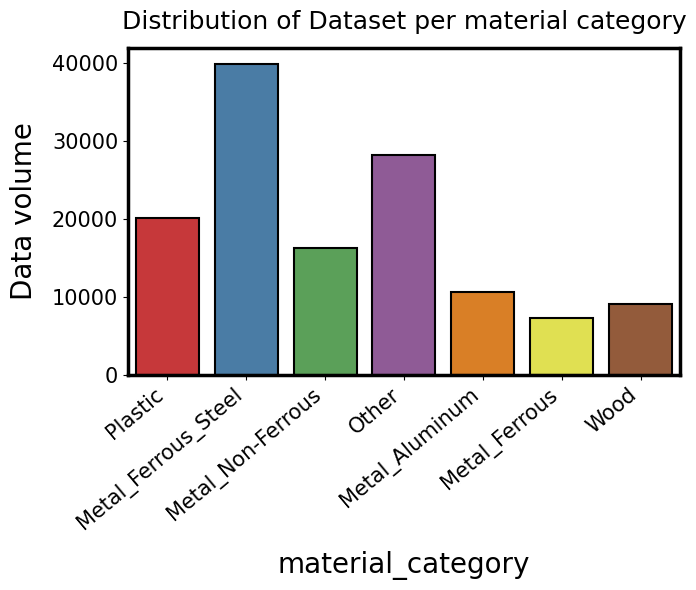

In [34]:
plot_data_distribution(consolidated_dataset_cleaned, 'material_category', 
                       'Distribution of Dataset per material category', 'material_category_distrubution')

Saving figure industries_distribution.png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


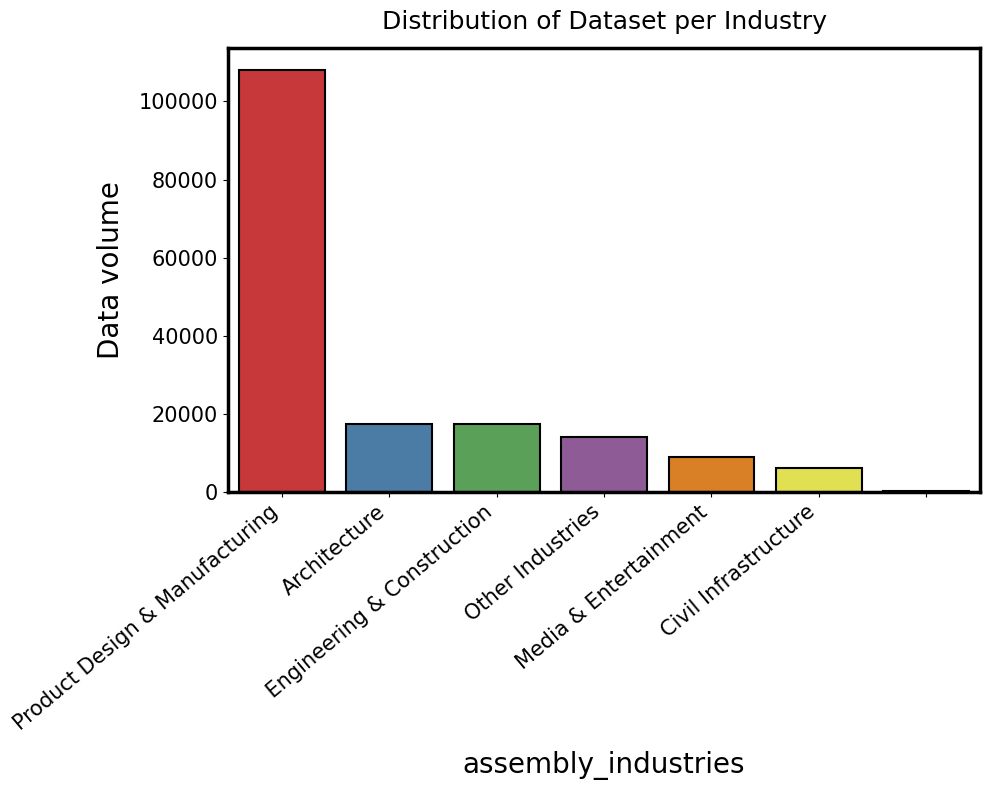

In [35]:
plot_multi_label_distribution(consolidated_dataset_cleaned, 'assembly_industries', 
                              'Distribution of Dataset per Industry', 'industries_distribution', figure_size = (10,8))

Saving figure Category Distrubution.png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


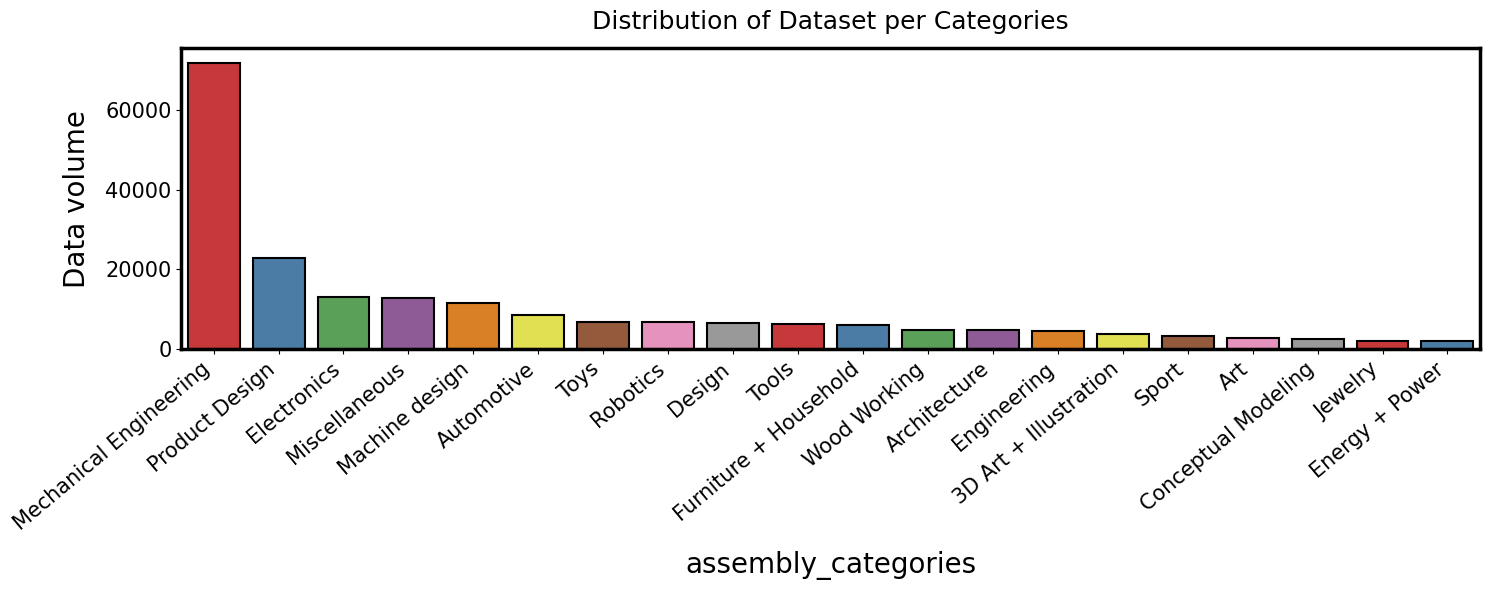

In [36]:
plot_multi_label_distribution_selected(consolidated_dataset_cleaned, 'assembly_categories', 
                              'Distribution of Dataset per Categories', 'Category Distrubution', 
                            figure_size = (15,6), top_n=20)

### Save the consolidated dataset

In [289]:
consolidated_dataset_cleaned.to_csv(os.path.join(Feature_PATH, "consolidated_dataset_v4.csv"), index=False)

In [290]:
consolidated_dataset_cleaned.iloc[:4000, :].to_csv(os.path.join(Feature_PATH, "consolidated_dataset_v4_example.csv"), index=False)

# Data Transformation 

Convert the extracted features into a format suitable for feeding into a machine learning model, i.e., a tabular form where each row represents a part and columns represent the feature.

Before feeding the data to a machine learning model, it's essential to preprocess the __textual and categorical__ features to ensure they're in a numerical format. Here's what we can do with those textual information:

- __One-hot Encoding__ for Single Categorical Features: For features like ___assembly_design_type___, which have a single categorical value for each row, can use one-hot encoding. This technique will convert each unique category into a new binary column, where a "1" indicates the presence of that category and a "0" indicates its absence.
- __Multi-label Binarization for multiple categoriacal features__: For features like ___assembly_industries___, which can have multiple values (or labels) in a single row, can use multi-label binarization. This technique will also convert each unique category into a new binary column, similar to one-hot encoding, but it can handle multiple "1s" in the same row.

### Data to be transformed: 
- uuid is a unique identifier and should probably be removed or not used as a feature.- 
nameise textual and would require a different kind of processing (like text embedding, or using LLMs.

- __type__, __material_category__, and __assembly_design_type__ can be **one-hot encoded**, but since they are pretty trivial, I will just drop them
- __assembly_categories__ and __assembly_industries__ appear to be **multi-label** categorical columns and would require multi-label binarization.on.

In [37]:
def transform_features(dataset):
    # Drop uuid and name columns
    dataset = dataset.drop(columns=['name','type', 'assembly_design_type' ])
    original_columns = set(dataset.columns)
    
    # Convert the categorical target 'material_category' to ordinal numbers
    # Initialize the encoder
    encoder = LabelEncoder()
    # Fit the encoder on the 'material_category' column
    encoder.fit(dataset['material_category'])
    dataset['Material Category (Target)'] = encoder.transform(dataset['material_category'])
    
    # One-Hot Encoding for 'type' and 'assembly_design_type'
    # dataset = pd.get_dummies(dataset, columns=['type', 'assembly_design_type'])
    one_hot_encoded = pd.get_dummies(dataset['material_category'])
    dataset = pd.concat([dataset, one_hot_encoded], axis=1)

    # Determine the new columns
    new_columns = set(dataset.columns) - original_columns
    
    # Multi-label Binarization for 'assembly_categories' and 'assembly_industries' with cleaned labels
    for col in ['assembly_categories', 'assembly_industries']:
        # Split the comma-separated string into a list of labels, handle NaNs and strip whitespace
        dataset[col] = dataset[col].str.split(',').fillna('').apply(lambda x: [item.strip() for item in x])
        mlb = MultiLabelBinarizer()
        col_encoded = mlb.fit_transform(dataset[col])
        col_df = pd.DataFrame(col_encoded, columns=mlb.classes_, index=dataset.index)
        dataset = pd.concat([dataset, col_df], axis=1)
        dataset = dataset.drop(columns=[col])
    
    return dataset, encoder, list(new_columns)

# Apply the transformations
transformed_dataset, encoder, one_hot_columns = transform_features(consolidated_dataset_cleaned)
# Drop one of the redundant 'Architecture' columns
transformed_dataset_cleaned = transformed_dataset.drop(columns=['Architecture']).drop(columns=[''])
transformed_dataset_cleaned

uuid  com_distance  center_of_mass_x  \
0       f130d4f0-054c-11ec-a094-0a2b8709b52f      0.042693      9.170593e-16   
1       f1314a74-054c-11ec-ac03-0a2b8709b52f      0.381353     -2.057905e-09   
2       f131bfb6-054c-11ec-9eb4-0a2b8709b52f      0.774408     -2.066062e-09   
3       f13234e8-054c-11ec-8b13-0a2b8709b52f      0.704245      9.170593e-16   
4       f13282ee-054c-11ec-aa03-0a2b8709b52f      0.698344      9.170593e-16   
...                                      ...           ...               ...   
131243  f95a09b6-0613-11ec-b131-0226f5980261     16.922193      6.132067e-01   
131244  f95a5828-0613-11ec-ab9b-0226f5980261     16.950769      0.000000e+00   
131245  f95a7efe-0613-11ec-bc18-0226f5980261     16.961065     -6.182051e-17   
131246  f95acd26-0613-11ec-a896-0226f5980261     16.952311      0.000000e+00   
131247  f95af41c-0613-11ec-8208-0226f5980261     16.944526      3.451123e-17   

        center_of_mass_y  center_of_mass_z  body_area  body_volume  \
0               2.846286      5.060009e-13   1.892846     0.064315   
1               2.423258     -2.936297e-02   0.659531     0.007196   
2               2.421404      6.705135e-01   0.657318     0.007167   
3               2.846286      7.000000e-01   1.892846     0.064315   
4               2.846286     -7.000000e-01   1.892846     0.064315   
...                  ...               ...        ...          ...   
131243          0.000000     -2.670490e-11   1.729151     0.116680   
131244          0.181651      1.007575e-11   0.129364     0.002853   
131245         -0.011000      8.108617e-12   0.016467     0.000024   
131246          0.150000      1.045680e-11   0.109956     0.002356   
131247          0.325000     -1.045678e-11   0.094248     0.001571   

          material_category  volume_fraction  bounding_box_max_x  ...  Toys  \
0                   Plastic     2.998711e-01            0.300000  ...     0   
1       Metal_Ferrous_Steel     3.355055e-02            0.300000  ...     0   
2         Metal_Non-Ferrous     3.341809e-02            0.300000  ...     0   
3                     Other     2.998711e-01            0.300000  ...     0   
4                   Plastic     2.998711e-01            0.300000  ...     0   
...                     ...              ...                 ...  ...   ...   
131243  Metal_Ferrous_Steel     3.891523e-04            5.662714  ...     0   
131244  Metal_Ferrous_Steel     9.514891e-06            5.662714  ...     0   
131245  Metal_Ferrous_Steel     7.997061e-08            5.662714  ...     0   
131246  Metal_Ferrous_Steel     7.858430e-06            5.662714  ...     0   
131247  Metal_Ferrous_Steel     5.238953e-06            5.662714  ...     0   

        Utilities & Telecom  Virtual Reality  Water & Wastewater  \
0                         0                0                   0   
1                         0                0                   0   
2                         0                0                   0   
3                         0                0                   0   
4                         0                0                   0   
...                     ...              ...                 ...   
131243                    0                0                   0   
131244                    0                0                   0   
131245                    0                0                   0   
131246                    0                0                   0   
131247                    0                0                   0   

        Wood Working  Civil Infrastructure  Engineering & Construction  \
0                  0                     0                           0   
1                  0                     0                           0   
2                  0                     0                           0   
3                  0                     0                           0   
4                  0                     0                           0   
...              ...        

In [38]:
one_hot_columns

['Metal_Non-Ferrous',
 'Metal_Ferrous_Steel',
 'Material Category (Target)',
 'Plastic',
 'Metal_Ferrous',
 'Metal_Aluminum',
 'Other',
 'Wood']

In [39]:
%store encoder

Stored 'encoder' (LabelEncoder)


In [40]:
transformed_dataset_cleaned.columns

Index(['uuid', 'com_distance', 'center_of_mass_x', 'center_of_mass_y',
       'center_of_mass_z', 'body_area', 'body_volume', 'material_category',
       'volume_fraction', 'bounding_box_max_x',
       ...
       'Toys', 'Utilities & Telecom', 'Virtual Reality', 'Water & Wastewater',
       'Wood Working', 'Civil Infrastructure', 'Engineering & Construction',
       'Media & Entertainment', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object', length=186)

### Save the transformed dataset

In [41]:
column_name = "Wood"
if column_name in transformed_dataset_cleaned.columns:
    print(f"'{column_name}' is in the DataFrame.")
else:
    print(f"'{column_name}' is not in the DataFrame.")

'Wood' is in the DataFrame.


In [42]:
material_list = ['Metal_Non-Ferrous',
                 'Metal_Ferrous',
                 'Plastic',
                 'Other',
                 'Metal_Ferrous_Steel',
                 'Metal_Aluminum',
                 'Wood']

In [43]:
transformed_dataset_cleaned_save = transformed_dataset_cleaned.drop(columns=material_list)

In [44]:
%store transformed_dataset_cleaned_save

Stored 'transformed_dataset_cleaned_save' (DataFrame)


In [45]:
nan_cols = transformed_dataset_cleaned_save.columns[transformed_dataset_cleaned_save.isna().any()].tolist()
print(nan_cols)

[]


In [304]:
transformed_dataset_cleaned_save.to_csv(os.path.join(Feature_PATH, "feature_transformed_cleaned_v4.csv"), index=False)

In [46]:
# List of all material categories
df_transformed_X = transformed_dataset_cleaned.drop(columns=['material_category', 'uuid']).drop(columns=one_hot_columns)
df_transformed_X_cleaned = df_transformed_X.fillna(df_transformed_X.median())

In [47]:
df_transformed_X.columns[df_transformed_X.isna().any()].tolist()

[]

## Data feature analysis

Saving figure correlation matrix (Material Category (Target)) - spearman
Saving figure correlation matrix (Metal_Ferrous) - spearman
Saving figure correlation matrix (Plastic) - spearman
Saving figure correlation matrix (Other) - spearman
Saving figure correlation matrix (Metal_Aluminum) - spearman
Saving figure correlation matrix (Wood) - spearman
Saving figure correlation matrix (Metal_Ferrous_Steel) - spearman
Saving figure correlation matrix (Metal_Non-Ferrous) - spearman


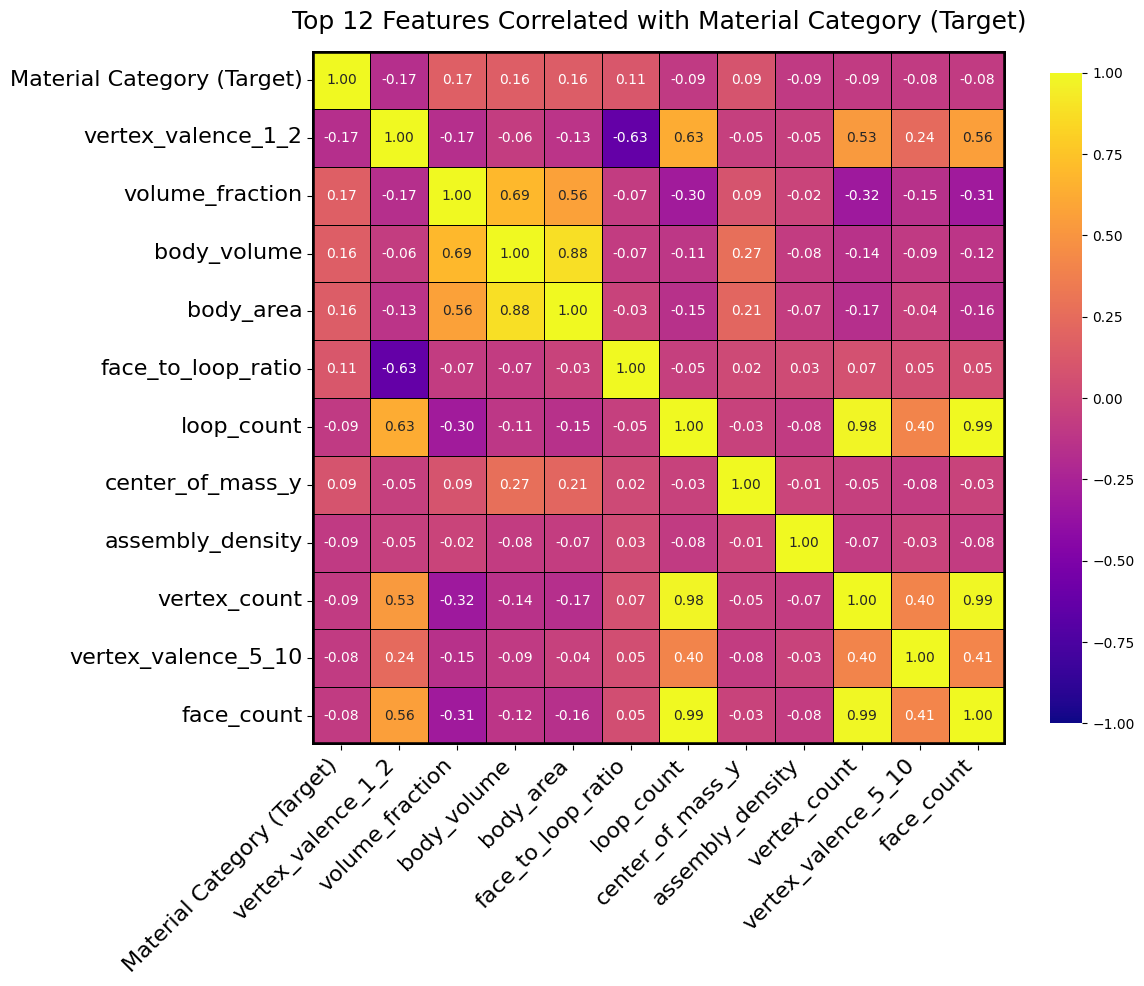

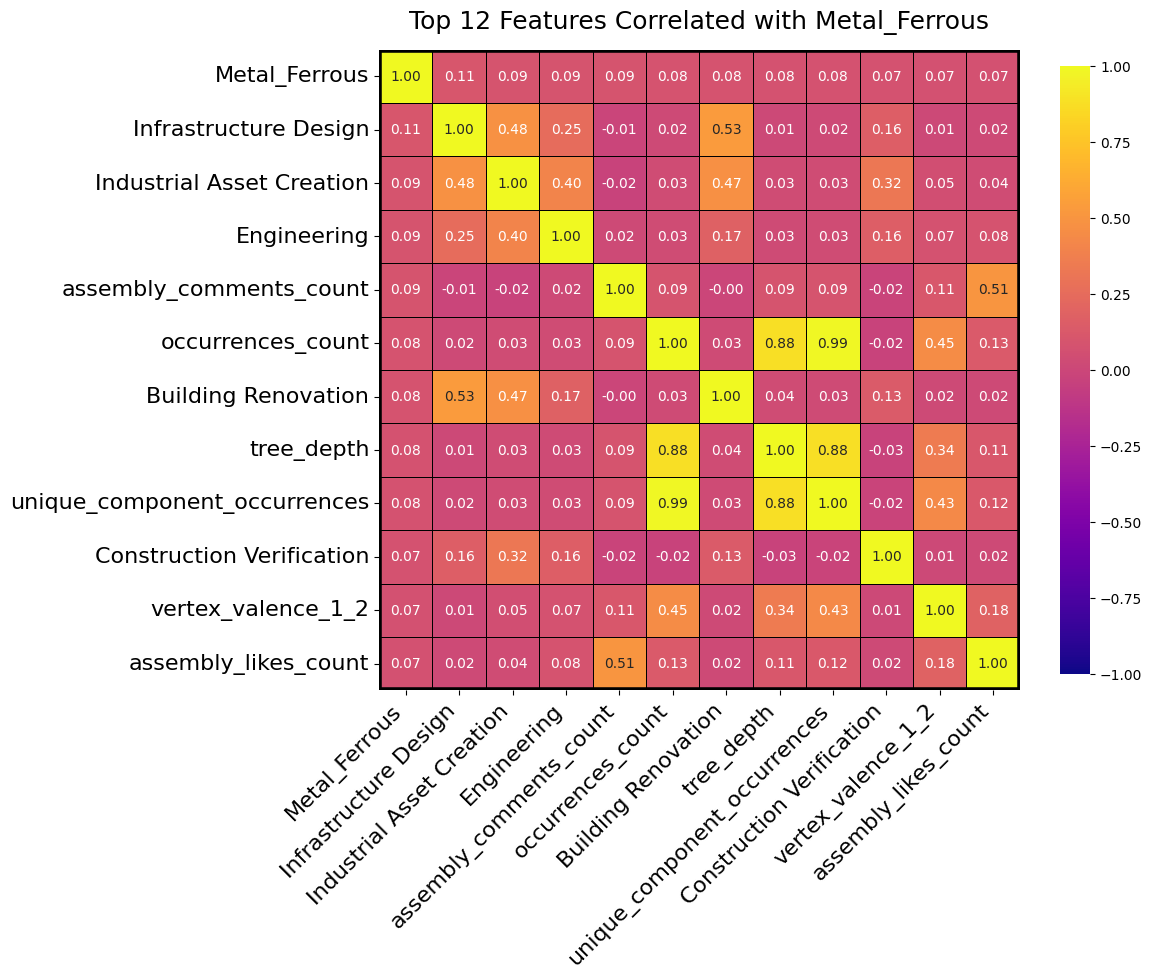

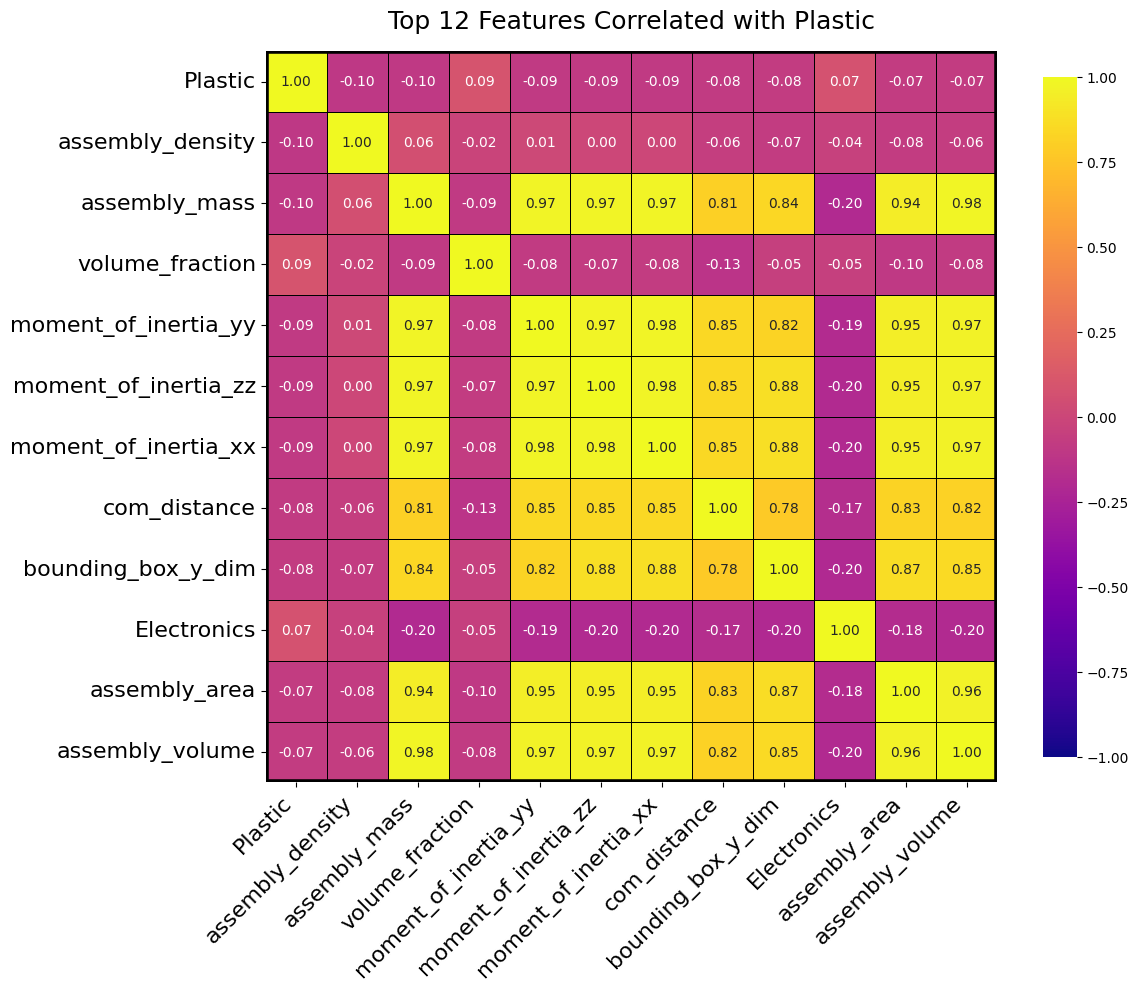

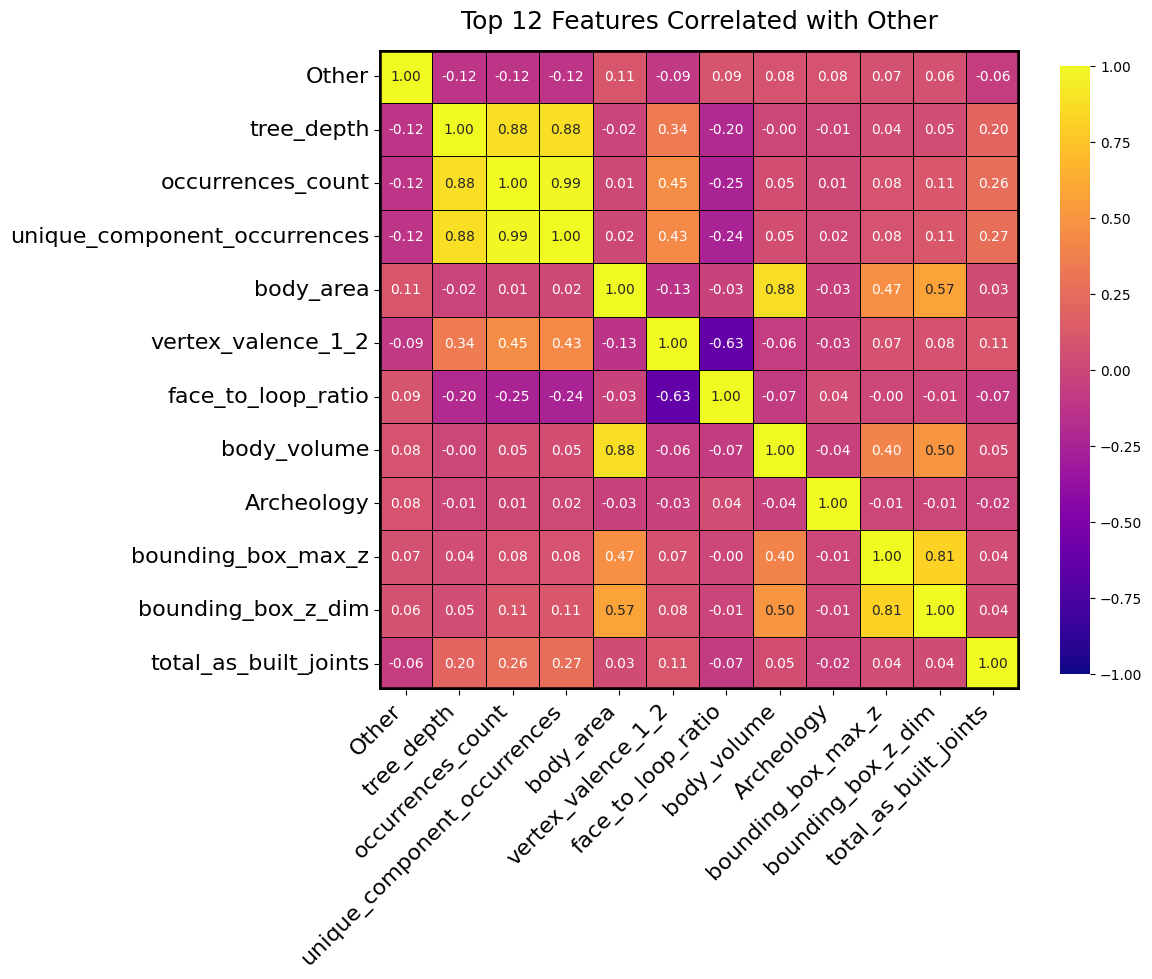

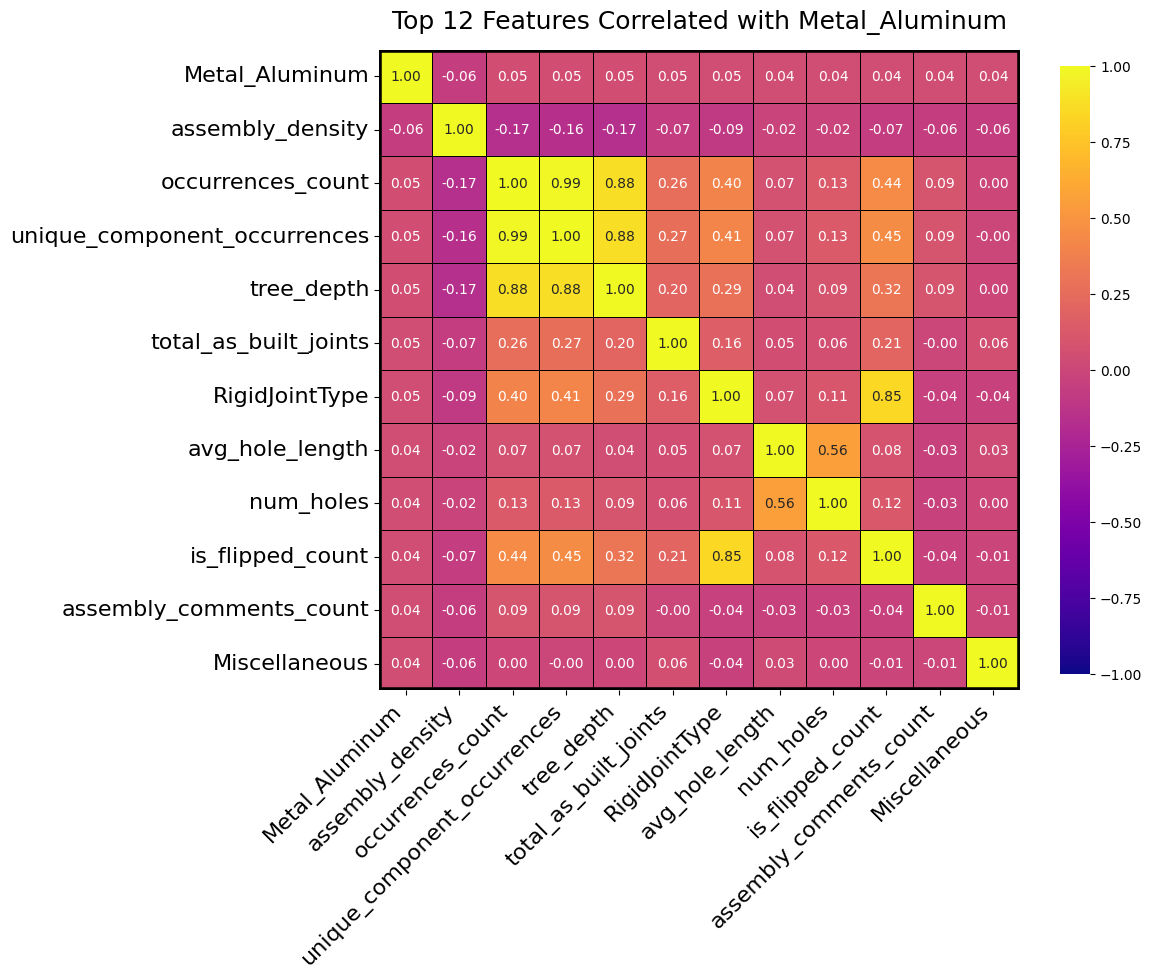

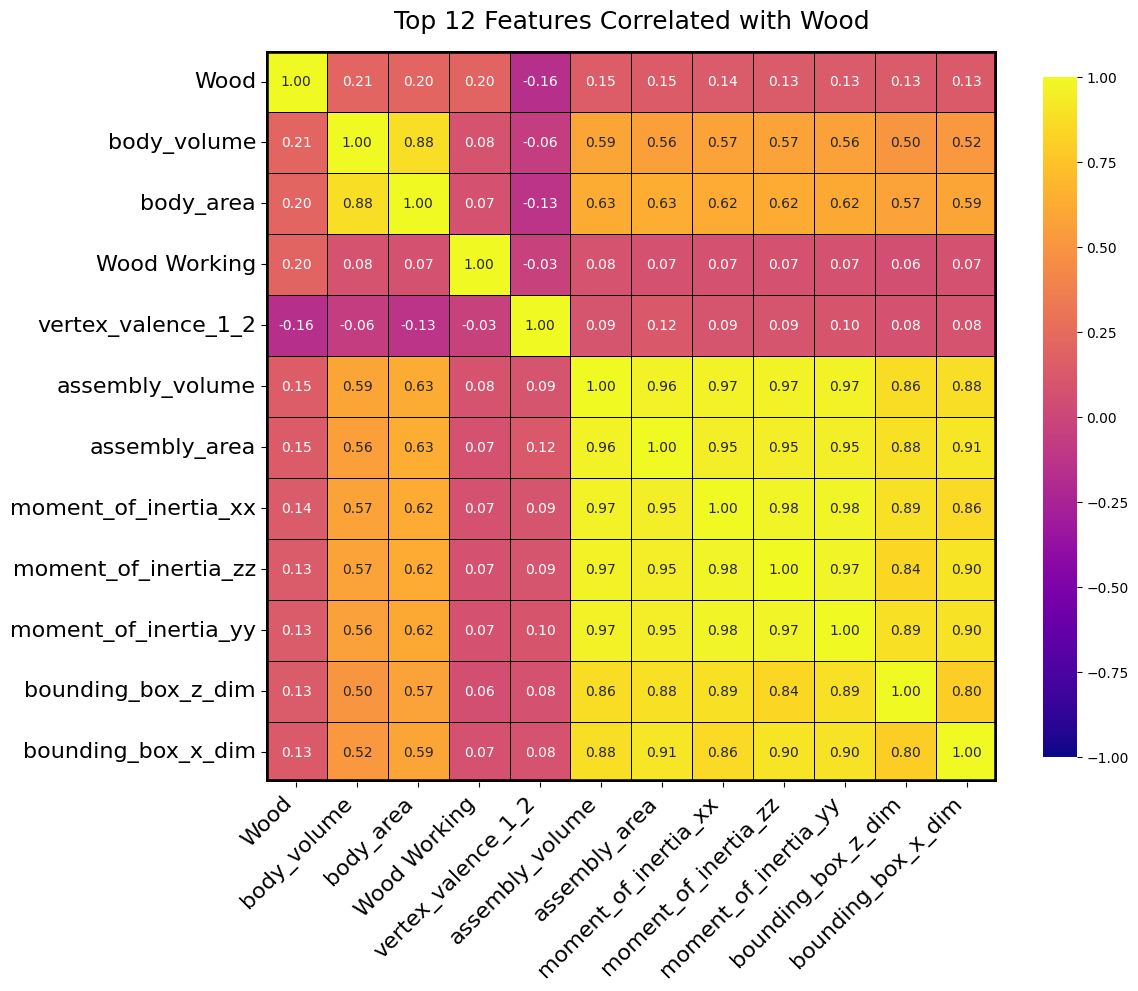

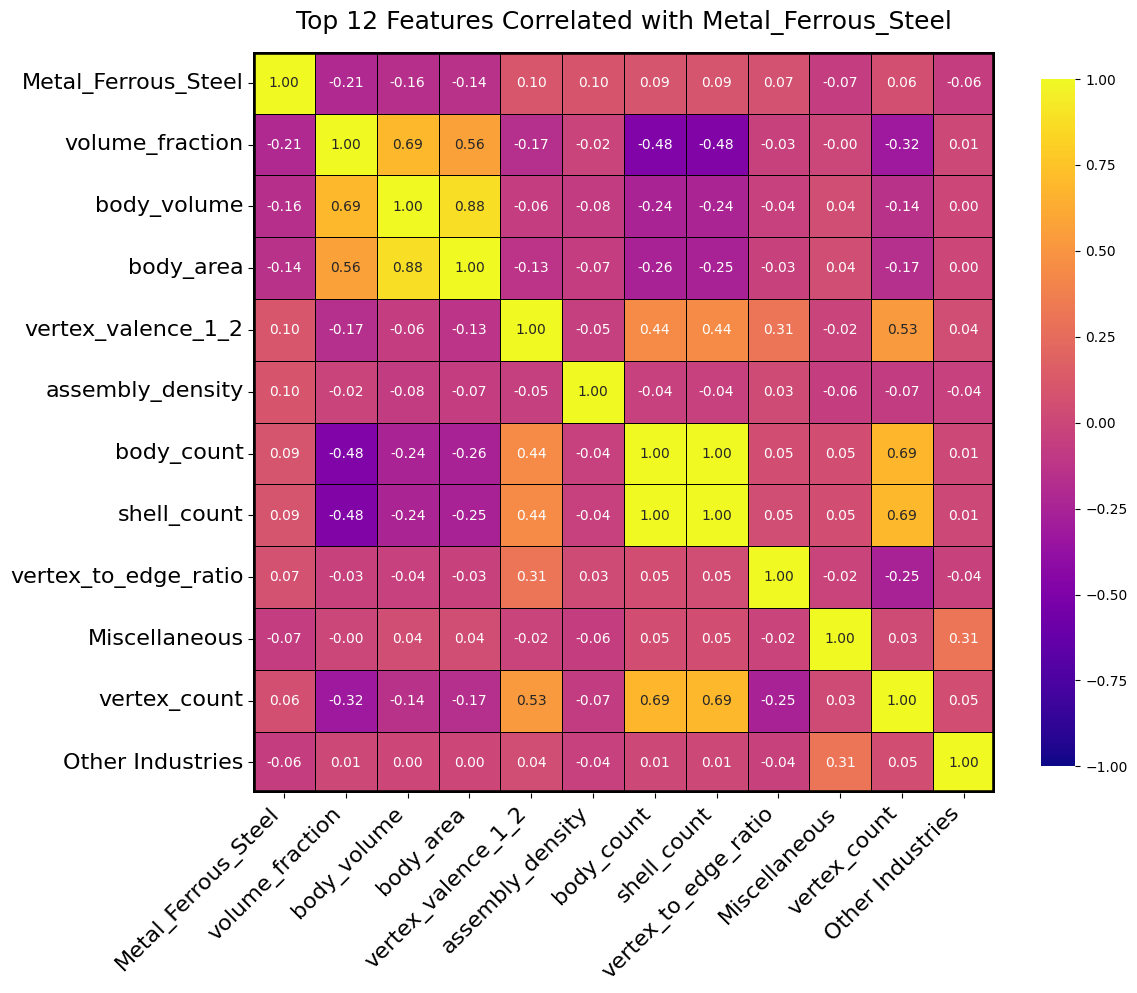

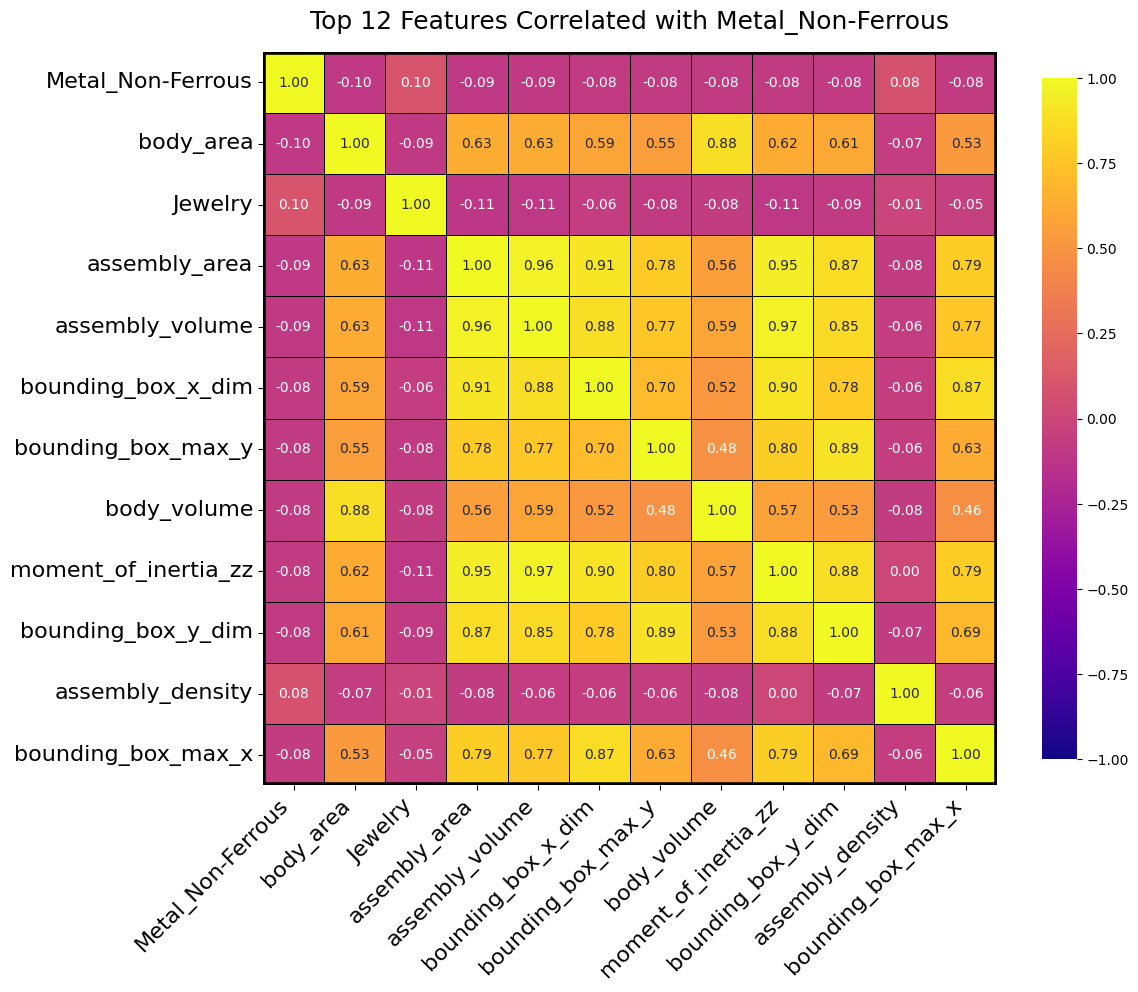

In [302]:
def plot_custom_style_top_correlated_features(dataset, target_column, method = 'spearman', top_n=10):
    # List of all material categories
    material_categories = ['Material Category (Target)', 'Metal_Ferrous','Plastic','Other',
                           'Metal_Aluminum','Wood','Metal_Ferrous_Steel','Metal_Non-Ferrous']

    # Remove the target column from the list
    material_categories.remove(target_column)

    # Drop the other material categories from the dataset
    dataset_dropped = dataset.drop(columns=material_categories)
    
    # Compute correlations with the target column using Spearman/pearson correlation
    correlations_with_target = dataset_dropped.corr(method=method)[target_column].drop(target_column)
    
    # Get top N absolute correlations (including the target)
    top_correlations = correlations_with_target.abs().nlargest(top_n - 1).index
    top_correlations = top_correlations.insert(0, target_column)
    top_correlation_values = dataset[top_correlations].corr(method=method)
    
    # Plot the heatmap with the provided style
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    # plt.show()
    # Save the figure
    save_fig(f"correlation matrix ({target_column}) - {method}")

# List of all material categories
material_categories = ['Material Category (Target)', 'Metal_Ferrous', 'Plastic', 'Other',
                       'Metal_Aluminum', 'Wood', 'Metal_Ferrous_Steel', 'Metal_Non-Ferrous']

# Loop over each material category to generate the plot
for material in material_categories:
    plot_custom_style_top_correlated_features(transformed_dataset_cleaned, material, method='spearman', top_n=12)

### Feature importance ranking by RF

body_area                    0.066714
volume_fraction              0.055887
body_volume                  0.054623
com_distance                 0.044190
center_of_mass_y             0.042782
center_of_mass_z             0.038498
center_of_mass_x             0.035397
assembly_density             0.022166
body_count                   0.019700
shell_count                  0.019527
vertex_valence_1_2           0.016212
face_to_loop_ratio           0.016040
assembly_views_count         0.015448
vertex_to_edge_ratio         0.015173
aspect_ratio_yz              0.015071
assembly_area                0.014131
bounding_box_z_dim           0.013930
bounding_box_max_z           0.013913
assembly_volume              0.013912
assembly_center_of_mass_z    0.013690
bounding_box_max_y           0.013651
aspect_ratio_xz              0.013626
assembly_mass                0.013607
aspect_ratio_xy              0.013593
bounding_box_y_dim           0.013568
assembly_center_of_mass_x    0.013501
assembly_cen

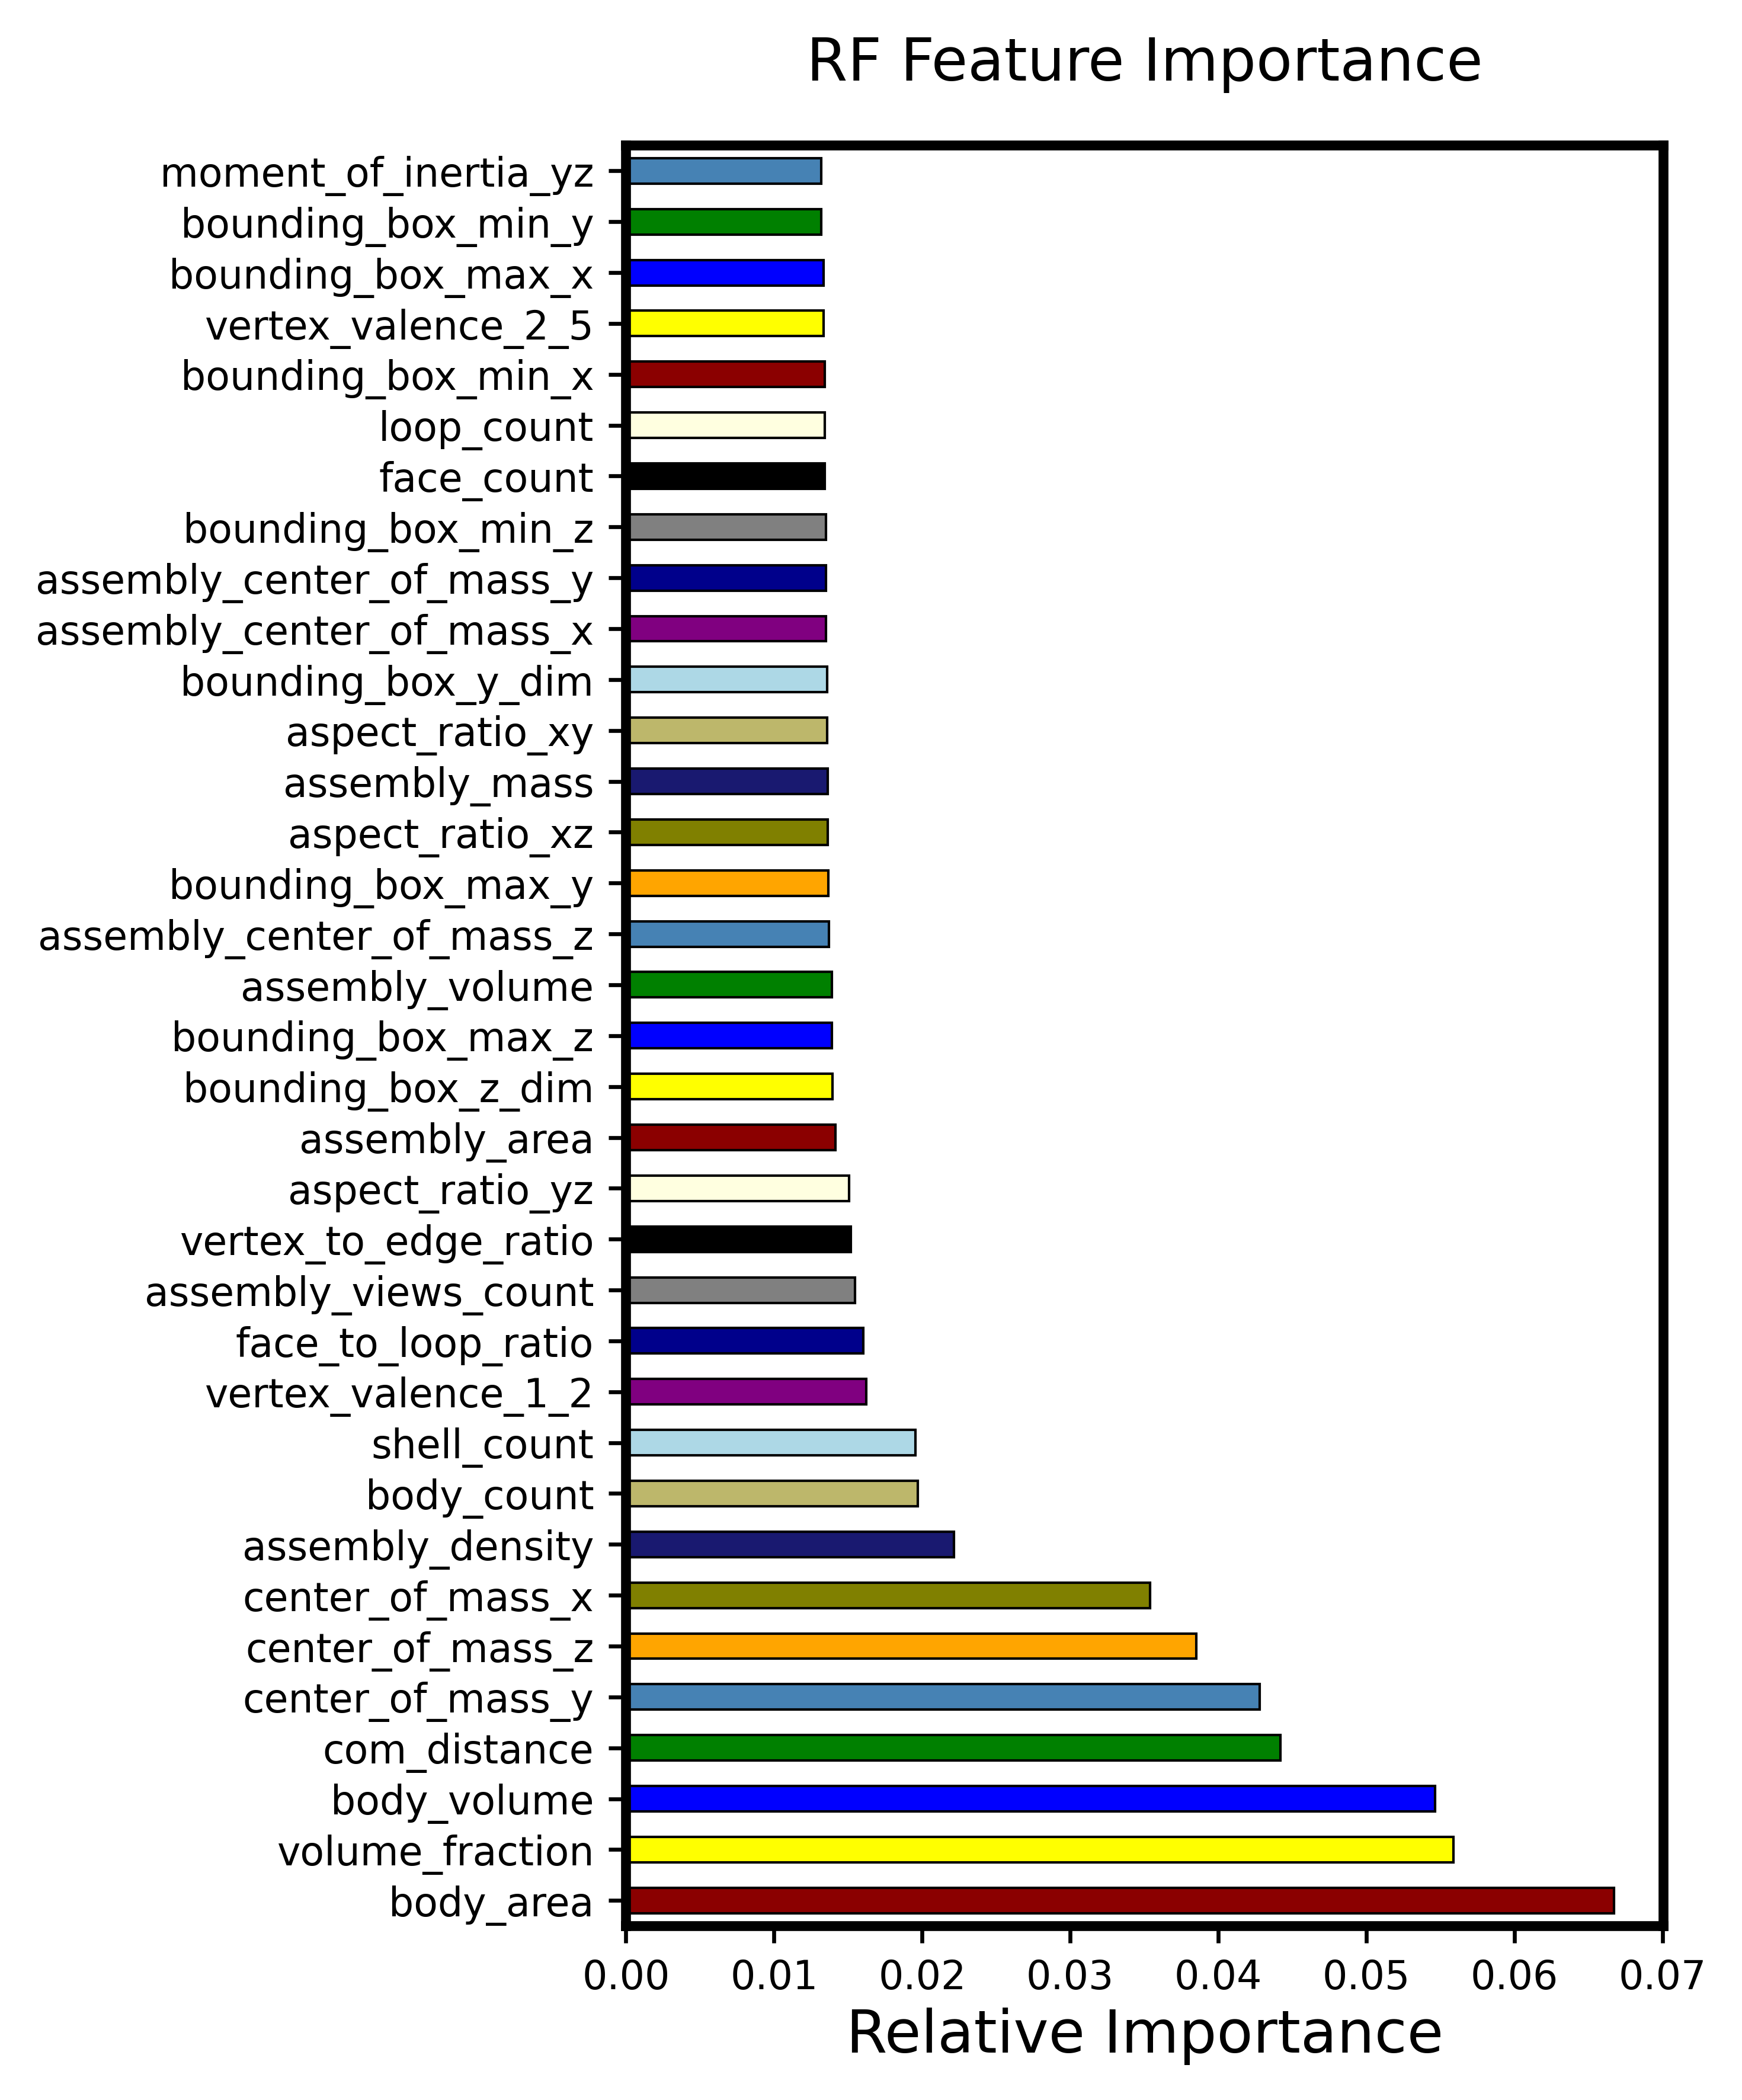

In [303]:
# Define the dataset and target variable
y = transformed_dataset_cleaned['Material Category (Target)']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
model.fit(df_transformed_X_cleaned, y)

# Extract feature importances
feat_importances = pd.Series(model.feature_importances_, index=df_transformed_X_cleaned.columns)


# Plotting the feature importances
fig = plt.figure(figsize=(5,6), dpi=600)
ax = plt.gca()
widths = 2
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)
    
color = ['darkred','yellow', 'blue','green', 'steelblue','orange', 'olive', 'midnightblue', 'darkkhaki', 
         "lightblue", "purple", "darkblue", "gray", "black", "lightyellow"]

feat_importances.nlargest(35).plot(kind='barh', color=color, edgecolor='k', linewidth=0.5)
plt.title("RF Feature Importance", fontsize=12, y=1.02)
plt.xlabel('Relative Importance', fontsize=12, labelpad=2)
plt.tick_params(axis='both', labelsize=8, pad=3)

# Displaying the top 15 feature importances
top_feature_importances = feat_importances.nlargest(35)
print (top_feature_importances)
save_fig("RF feature importance ranking (35)")

## Visualization and dimensionality reduction

In [244]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_columns = df_transformed_X_cleaned.select_dtypes(include=np.number).columns
df_transformed_X_cleaned[numeric_columns] = scaler.fit_transform(df_transformed_X_cleaned[numeric_columns])

In [245]:
df_normalized.head()

com_distance  center_of_mass_x  center_of_mass_y  center_of_mass_z  \
0     -0.021812         -0.008718         -0.031951         -0.026401   
1     -0.021796         -0.008718         -0.031969         -0.026406   
2     -0.021777         -0.008718         -0.031969         -0.026289   
3     -0.021781         -0.008718         -0.031951         -0.026284   
4     -0.021781         -0.008718         -0.031951         -0.026518   

   body_area  body_volume  volume_fraction  bounding_box_max_x  \
0   -0.00337    -0.002827        -0.003198            -0.01904   
1   -0.00337    -0.002827        -0.003198            -0.01904   
2   -0.00337    -0.002827        -0.003198            -0.01904   
3   -0.00337    -0.002827        -0.003198            -0.01904   
4   -0.00337    -0.002827        -0.003198            -0.01904   

   bounding_box_max_y  bounding_box_max_z  ...      Toys  Utilities & Telecom  \
0           -0.029983           -0.022853  ... -0.236582            -0.031368   
1           -0.029983           -0.022853  ... -0.236582            -0.031368   
2           -0.029983           -0.022853  ... -0.236582            -0.031368   
3           -0.029983           -0.022853  ... -0.236582            -0.031368   
4           -0.029983           -0.022853  ... -0.236582            -0.031368   

   Virtual Reality  Water & Wastewater  Wood Working  Civil Infrastructure  \
0        -0.088549           -0.026197     -0.192919              -0.22234   
1        -0.088549           -0.026197     -0.192919              -0.22234   
2        -0.088549           -0.026197     -0.192919              -0.22234   
3        -0.088549           -0.026197     -0.192919              -0.22234   
4        -0.088549           -0.026197     -0.192919              -0.22234   

   Engineering & Construction  Media & Entertainment  Other Industries  \
0                    -0.38985              -0.269708         -0.347845   
1                    -0.38985              -0.269708         -0.347845   
2                    -0.38985              -0.269708         -0.347845   
3                    -0.38985              -0.269708         -0.347845   
4                    -0.38985              -0.269708         -0.347845   

   Product Design & Manufacturing  
0                        0.461865  
1                        0.461865  
2                        0.461865  
3                        0.461865  
4                        0.461865  

[5 rows x 128 columns]

In [246]:
## check NaN columns
nan_cols = df_normalized.columns[df_normalized.isna().any()].tolist()
print(nan_cols)

[]


In [247]:
df_normalized[nan_cols] = df_normalized[nan_cols].fillna(0)

In [248]:
# dimensionality reduction with 18 features
pca= PCA(n_components=12)
pca.fit(df_normalized)
print(pca.explained_variance_ratio_)

[0.16996473 0.09122198 0.04769052 0.03127415 0.02664308 0.02361062
 0.02122043 0.02054307 0.01825088 0.01668233 0.0164008  0.0152874 ]


Saving figure PCA_all.png


C:\Users\Asus\AppData\Local\Temp\ipykernel_22748\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


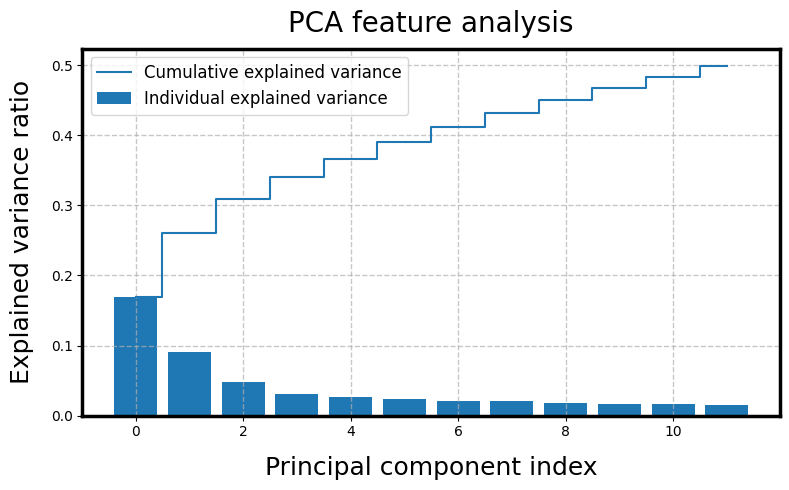

In [249]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot

plt.figure(figsize=(8, 5)) 
plt.grid(linestyle='--', linewidth=1, alpha=0.7)
plt.title("PCA feature analysis", fontsize = 20, pad = 12)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=1.0, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', fontsize = 18, labelpad=12)
plt.xlabel('Principal component index', fontsize = 18, labelpad=12)
plt.legend(loc='best', fontsize="large")
plt.tight_layout()
# plt.show()
save_fig('PCA_all.png')

In [250]:
import matplotlib.patches
    
def two_d_pca_projection (df_normalized, name):
    pca_2 = PCA(n_components=2)
    pca_2.fit(df_normalized)
    # dimensionality reduction -> output is reduced feature space
    data_pca_2 = pca_2.transform(df_normalized)

    plt.figure(figsize=(6, 4))
    levels, categories = pd.factorize(transformed_dataset_cleaned['material_category'])
    colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
    handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

    xdata = data_pca_2[:, 0]
    ydata = data_pca_2[:, 1]

    plt.scatter(xdata, ydata, c=colors, alpha=0.8, s=10)
    plt.xlabel('Principal component 1',fontsize=16, labelpad=13)
    plt.ylabel('Principal component 2',fontsize=16, labelpad=13)
    # plt.title('PCA Projection ' + name,fontsize=20, pad=12)
    # plt.gca().set(xlabel='Principle component 1', ylabel='Principle component 2', title='PCA dimensionality reduction', set_fontsize=12)
    plt.legend(handles=handles, loc='upper left', fontsize='large') # title='Color'
    save_fig("PCA_2D_" + name)

def three_d_pca_projection (df_normalized, name):
    pca_3 = PCA(n_components=3)
    pca_3.fit(df_normalized)
    # dimensionality reduction -> output is reduced feature space
    data_pca_3 = pca_3.transform(df_normalized)

    fig = plt.figure(figsize=(9, 6))
    ax = plt.axes(projection='3d')

    levels, categories = pd.factorize(transformed_dataset_cleaned['material_category'])
    colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
    handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]


    # Data for three-dimensional scattered points
    xdata = data_pca_3[:, 1]
    ydata = data_pca_3[:, 2]
    zdata = data_pca_3[:, 0]
    # ax.scatter3D(xdata, ydata, zdata,
    #              c=df_denoised_normalized["laser power"], edgecolor='none', alpha=0.9, s=40,
    #              cmap=plt.cm.get_cmap('Set1', 4)); # cmap='Greens'

    ax.scatter3D(xdata, ydata, zdata,edgecolor='none', alpha=0.8, s=30,
                 c=colors); # cmap='Greens'

    ax.set_xlabel('PCA 1',fontsize=16, labelpad=13)
    ax.set_ylabel('PCA 1',fontsize=16, labelpad=13)
    ax.set_zlabel('PCA 1',fontsize=16, labelpad=13)
    # ax.set_title("PCA 3D projection " + name, fontsize = 20, pad = 5)
    # plt.colorbar();
    plt.legend(handles=handles, loc='best', fontsize=11) #; upper left # title='Color'
    save_fig("PCA_3D_" + name)

Saving figure PCA_3D_all_feature


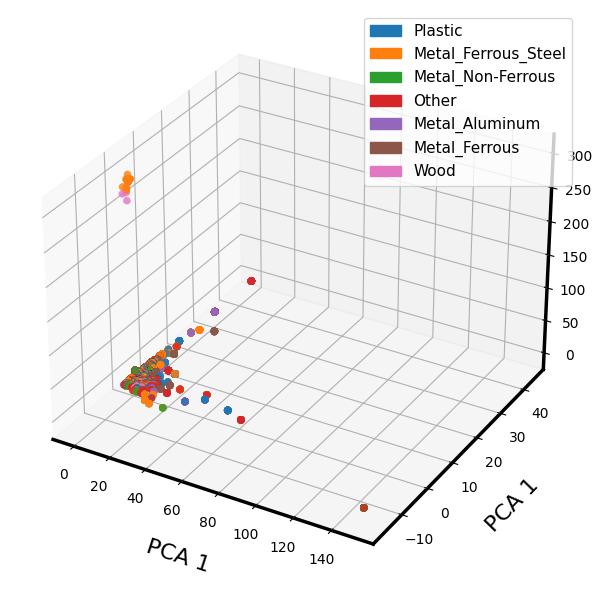

In [251]:
three_d_pca_projection(df_normalized, "all_feature")

Saving figure PCA_2D_all_features


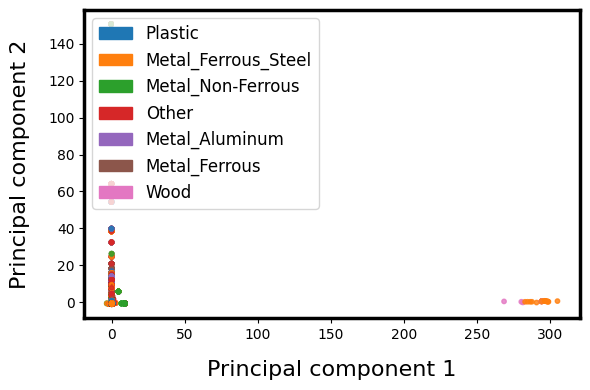

In [252]:
two_d_pca_projection(df_normalized, "all_features")

### Manifold Learning (dimensionality reduction) - A Comprehensive Comparison
- https://github.com/wepe/MachineLearning/blob/master/ManifoldLearning/DimensionalityReduction_DataVisualizing/data_visualizing.py

In [45]:
X = df_normalized.to_numpy()
y = transformed_dataset_cleaned['Material Category (Target)'].to_numpy()

In [46]:
y.shape

(131234,)

In [47]:
X.shape

(131234, 118)

In [48]:
# 2D visualization function
# color_list = [plt.cm.tab10(2), plt.cm.tab10(4),plt.cm.tab10(3), plt.cm.tab10(0)]
# color_list = ["#0fa14a", "#7a7c7f","#c24553", "#faaf42"]
# color_list = ["#0fa14a", "#7a7c7f", plt.cm.tab10(3), "#faaf42"]
color_list = [ "#faaf42", "#7a7c7f", plt.cm.tab10(3), "#0fa14a","#0fa14a", 
              "#c24553",plt.cm.tab10(3), plt.cm.tab10(0), plt.cm.tab10(4)]

def plot_embedding_2d(X, method_name, title=None):
    #MinMax scaled to [0,1]
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    # After dimension reduction, each point is:（X[i, 0], X[i, 1]）
    plt.figure(figsize=(6, 5))
    levels, categories = pd.factorize(transformed_dataset_cleaned['material_category'])
    colors = [color_list[i] for i in levels] # using the "plt.cm.tab10(i)" colormap
    handles = [matplotlib.patches.Patch(color=color_list[i], label=c) for i, c in enumerate(categories)]
    
    xdata = X[:, 0]
    ydata = X[:, 1]
    plt.scatter(xdata, ydata, c=colors, alpha=0.9, s=10, linewidths=0.1, edgecolors='k')
    xlabel = method_name + "-1"
    ylabel = method_name + "-2"
    plt.xlabel(xlabel,fontsize=20, labelpad=13)
    plt.ylabel(ylabel,fontsize=20, labelpad=13)
    plt.legend(handles=handles, loc='best', fontsize='large') #; upper left # title='Color'
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if title is not None:
        plt.title(title,fontsize=20, pad=12)

# 3D visualization function
def plot_embedding_3d(X, method_name, title=None):
    #MinMax scaled to [0,1]
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    # After dimension reduction, each point is:（X[i, 0], X[i, 1], X[i, 2]）
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    
    levels, categories = pd.factorize(transformed_dataset_cleaned['material_category'])
    colors = [color_list[i] for i in levels] # using the "plt.cm.tab10(i)" colormap
    handles = [matplotlib.patches.Patch(color=color_list[i], label=c) for i, c in enumerate(categories)]
    
    xdata = X[:, 0]
    ydata = X[:, 1]
    zdata = X[:, 2]
    
    ax.scatter3D(xdata, ydata, zdata,linewidths=0.1, edgecolor='k', alpha=0.9, s=14, c=colors); # cmap='Greens'
    xlabel = method_name + "-1"
    ylabel = method_name + "-2"
    zlable = method_name + "-3"

    ax.set_xlabel(xlabel,fontsize=16, labelpad=13)
    ax.set_ylabel(ylabel,fontsize=16, labelpad=13)
    ax.set_zlabel(zlable,fontsize=16, labelpad=13)
    if title is not None:
        ax.set_title(title,fontsize=20, pad = 5)
    plt.legend(handles=handles, loc='best', fontsize='large') #; upper left # title='Color'

Computing PCA projection


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:1067: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Saving figure PCA_2D


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


Saving figure PCA_3D
Computing LDA projection


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:1067: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Saving figure LDA_2D


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


Saving figure LDA_3D


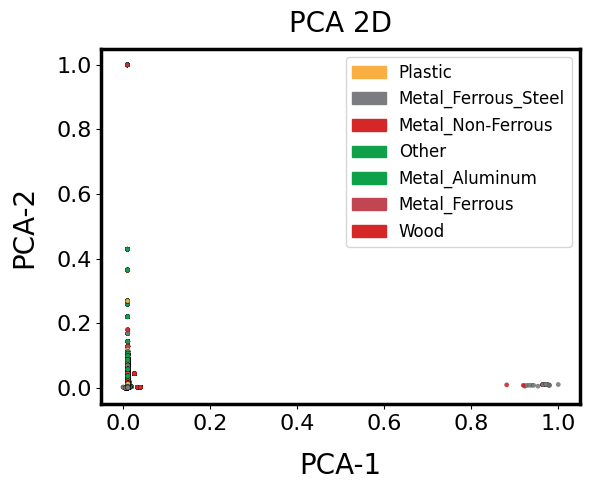

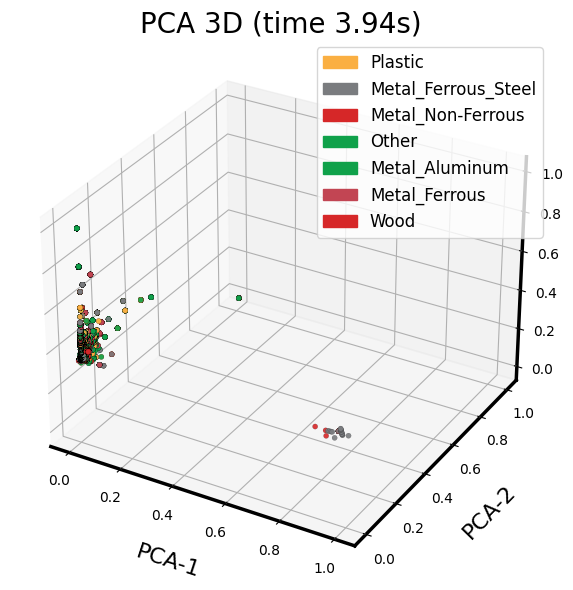

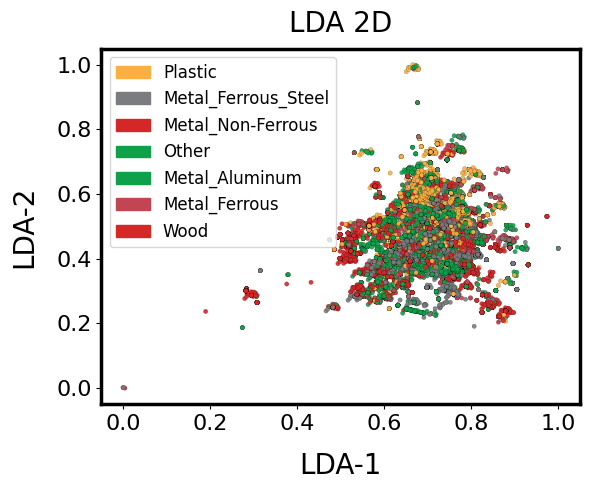

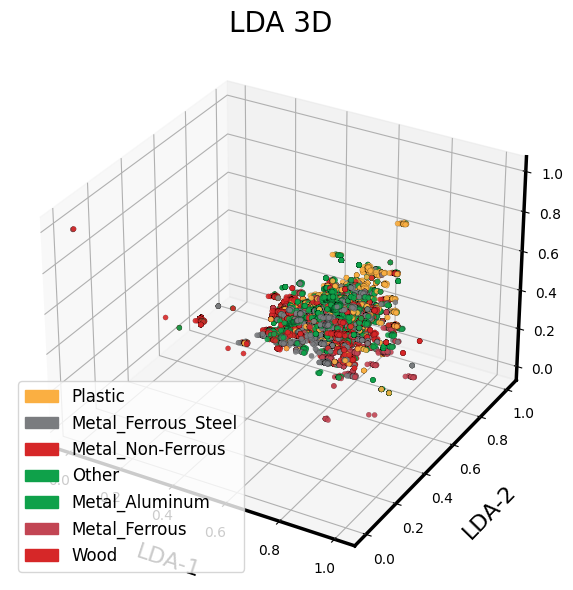

In [49]:
n_neighbors=10

# # # Random Projection
# print("Computing random projection")
# rp = random_projection.SparseRandomProjection(n_components=3, random_state=42)
# X_projected = rp.fit_transform(X)
# plot_embedding_2d(X_projected, "Random Projection", title="Random Projection")
# save_fig("Random Projection")
# plot_embedding_3d(X_projected,'Random Projection',"Random Projection 3D")
# save_fig("Random Projection-3D")

########------------------------------------#########
########---------------PCA------------------#########
########------------------------------------#########
print("Computing PCA projection")
t0 = time.time()
X_pca = decomposition.TruncatedSVD(n_components=3).fit_transform(X)
plot_embedding_2d(X_pca[:,0:2], 'PCA', title="PCA 2D")
save_fig("PCA_2D")
plot_embedding_3d(X_pca,'PCA', title ="PCA 3D (time %.2fs)" %(time.time() - t0))
save_fig("PCA_3D")


# ########------------------------------------#########
# ########---------------LDA------------------#########
# ########------------------------------------#########
print("Computing LDA projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time.time()
X_lda = LDA(n_components=3).fit_transform(X2, y)
plot_embedding_2d(X_lda[:,0:2],'LDA',  "LDA 2D" )
save_fig("LDA_2D")
plot_embedding_3d(X_lda,'LDA', "LDA 3D")
save_fig("LDA_3D")

# ########------------------------------------#########
# ########---------------Isomap---------------#########
# # ########------------------------------------#########
# print("Computing Isomap embedding")
# t0 = time.time()
# X_iso = manifold.Isomap(n_neighbors = n_neighbors, n_components=3).fit_transform(X)
# print("Done.")
# plot_embedding_2d(X_iso,"Isomap", "Isomap 2D")
# save_fig("Isomap_2D")
# plot_embedding_3d(X_iso,'Isomap', "Isomap 3D")
# save_fig("Isomap_3D")

Computing Totally Random Trees embedding


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:1067: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Saving figure Random_trees-2D


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\matplotlib\cbook\__init__.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


Saving figure Random Trees_3D


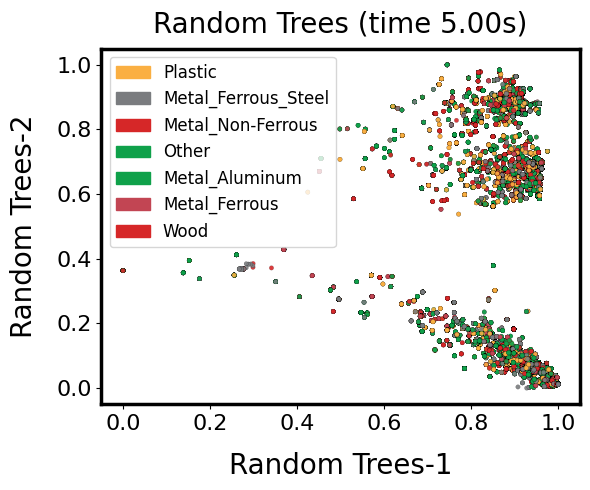

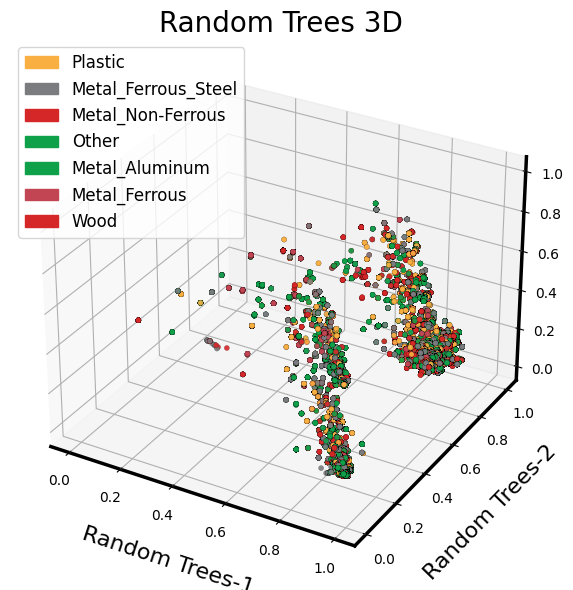

In [50]:
# ########------------------------------------#########
# ########-----------------MDS----------------#########
# ########------------------------------------#########
# print("Computing MDS embedding")
# clf = manifold.MDS(n_components=3, n_init=1, max_iter=100)
# t0 = time.time()
# X_mds = clf.fit_transform(X)
# print("Done. Stress: %f" % clf.stress_)
# plot_embedding_2d(X_mds,'MDS', "MDS (time %.2fs)" %(time.time() - t0))
# save_fig("MDS-2D")
# plot_embedding_3d(X_mds,'MDS', "MDS 3D")
# save_fig("MDS_3D")


# ########------------------------------------#########
# ########-------------Random Trees-----------#########
# ########------------------------------------#########
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,max_depth=5)
t0 = time.time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=3)
X_reduced = pca.fit_transform(X_transformed)
plot_embedding_2d(X_reduced,'Random Trees', "Random Trees (time %.2fs)" %(time.time() - t0))
save_fig("Random_trees-2D")
plot_embedding_3d(X_reduced,'Random Trees', "Random Trees 3D")
save_fig("Random Trees_3D")

In [51]:
# ########------------------------------------#########
# ########-------------------TSNE--------------#########
# ########------------------------------------#########
# # t-SNE
# print("Computing t-SNE embedding")
# tsne = manifold.TSNE(n_components=3, perplexity = 200, n_iter=5000, init='pca', random_state=0, n_jobs=-1)
# t0 = time.time()
# X_tsne = tsne.fit_transform(X)
# print (X_tsne.shape)
# plot_embedding_2d(X_tsne[:,0:2],'TSNE', "t-SNE 2D")
# save_fig("TSNE-2D")
# plot_embedding_3d(X_tsne,'TSNE',"t-SNE 3D (time %.2fs)" %(time.time() - t0))
# save_fig("TSNE-3D")

# Feature extraction for test set

In [51]:
input_test_dir = os.path.join (PROJECT_ROOT_DIR, 'dataset', 'test_data', 'Fusion360GalleryDataset_23hackathon_test_old')

In [52]:
def process_assemblies(input_dir):
    # Retrieve all the assembly JSON files from the directory
    input_jsons = get_all_files(input_dir, "*/assembly.json")
    
    # This will store all the extracted features from all files
    all_features = []
    
    for input_json in tqdm(input_jsons):
        with open(input_json, "r", encoding="utf-8") as f:
            assembly_data = json.load(f)

        # Extract features using our function
        extracted_features = extract_features_v4(assembly_data)
        
        # # Add the assembly filename as an additional feature for traceability
        # extracted_features['assembly_filename'] = str(input_json.parts[-2])
        
        all_features.append(extracted_features)
    
    # Concatenate all features into a single DataFrame
    consolidated_df = pd.concat(all_features, ignore_index=True)
    return consolidated_df


consolidated_test_dataset = process_assemblies(input_test_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.08it/s]


In [53]:
consolidated_test_dataset

uuid         name      type  \
0    bbdf29da-060c-11ec-a52a-02ef91e90f5f    Bolt M6-1  BRepBody   
1    bbdf9f22-060c-11ec-ac81-02ef91e90f5f         Ramp  BRepBody   
2    bbe89f86-060c-11ec-8111-02ef91e90f5f  Blade mount  BRepBody   
3    bbee1dec-060c-11ec-aabe-02ef91e90f5f  Fixed blade  BRepBody   
4    bbee44f6-060c-11ec-bd48-02ef91e90f5f      Bracket  BRepBody   
..                                    ...          ...       ...   
150  3b4ce74c-05cc-11ec-a9ce-064a63348d37       Pata_1  BRepBody   
151  3b4d0e4c-05cc-11ec-9c6d-064a63348d37       Pata_4  BRepBody   
152  3b4d355a-05cc-11ec-9f42-064a63348d37       Pata_3  BRepBody   
153  3b4d8388-05cc-11ec-acde-064a63348d37       Pata_2  BRepBody   
154  3b4daaa2-05cc-11ec-bc9f-064a63348d37        Body1  BRepBody   

     com_distance  center_of_mass_x  center_of_mass_y  center_of_mass_z  \
0       18.789386     -3.018946e-11     -1.019470e-16          0.872410   
1       17.384202      1.921808e+00     -6.312883e-01         -1.718481   
2       15.731161      3.467308e+00      2.811920e+00          6.277969   
3       13.623338      5.457923e+00     -1.478449e+00          0.795617   
4       10.639008      1.037246e+01     -1.650000e+00         -3.440546   
..            ...               ...               ...               ...   
150     66.832452      2.540000e+00      4.000000e+01          2.540000   
151     66.832452      1.025400e+02      4.000000e+01         72.540000   
152     66.832452      1.025400e+02      4.000000e+01          2.540000   
153     66.832452      2.540000e+00      4.000000e+01         72.540000   
154     14.015055      5.254000e+01      8.124696e+01         37.540000   

        body_area   body_volume    material_category  ...  min_joint_offset  \
0        7.679887      1.089020  Metal_Ferrous_Steel  ...               0.0   
1      972.513358    475.446755                Other  ...               0.0   
2      460.819725    241.470603                Other  ...               0.0   
3       73.200000     21.600000  Metal_Ferrous_Steel  ...               0.0   
4       54.622106     11.563476                Other  ...               0.0   
..            ...           ...                  ...  ...               ...   
150   1677.212800   2064.512000                 Wood  ...               0.0   
151   1677.212800   2064.512000                 Wood  ...               0.0   
152   1677.212800   2064.512000                 Wood  ...               0.0   
153   1677.212800   2064.512000                 Wood  ...               0.0   
154  27786.304206  33436.374783                 Wood  ...               0.0   

     max_joint_offset  RigidJointType  RevoluteJointType  SliderJointType  \
0                 0.0               0                  0                0   
1                 0.0               0                  0                0   
2                 0.0               0                  0                0   
3                 0.0               0                  0                0   
4                 0.0               0                  0                0   
..                ...             ...                ...              ...   
150               0.0               0                  0                0   
151               0.0               0                  0                0   
152               0.0               0                  0                0   
153               0.0               0                  0                0   
154               0.0               0                  0                0   

     CylindricalJointType  PinSlotJointType  PlanarJointType  BallJointType  \
0                       0                 0                0              0   
1                       0                 0                0              0   
2                       0                 0                0              0   
3                       0                 0                0              0   
4                       0                 0       

### Check if there is any inf values

In [54]:
import numpy as np

# Check for infinite values again
infinite_values = (consolidated_test_dataset == np.inf) | (consolidated_test_dataset == -np.inf)

# Count the infinite values in each column
infinite_counts = infinite_values.sum()

# Filter out columns with infinite values
infinite_counts = infinite_counts[infinite_counts > 0]

infinite_counts

Series([], dtype: int64)

No inf value found

### Check if there is any abnormaly large/small  values
These values could negatively influence the ML model performance, let's ignore them for now.

In [55]:
# Identify columns with very large values
large_values_threshold = 1e+30

# Filter numeric columns only
numeric_columns = consolidated_test_dataset.select_dtypes(include=[np.number])

# Identify columns with very large values in the numeric subset
large_values = (numeric_columns.abs() > large_values_threshold)

# Count the large values in each column
large_value_counts = large_values.sum()

# Filter out columns with large values
large_value_columns = large_value_counts[large_value_counts > 0]

large_value_columns

Series([], dtype: int64)

In [56]:
# Check the shape of the new cleaned dataset
consolidated_test_dataset.shape

(155, 109)

In [57]:
nan_cols = consolidated_test_dataset.columns[consolidated_test_dataset.isna().any()].tolist()
print(nan_cols)

[]


In [33]:
nan_cols = consolidated_dataset_cleaned.columns[consolidated_dataset_cleaned.isna().any()].tolist()
print(nan_cols)

[]


Saving figure material_category_distrubution (test).png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


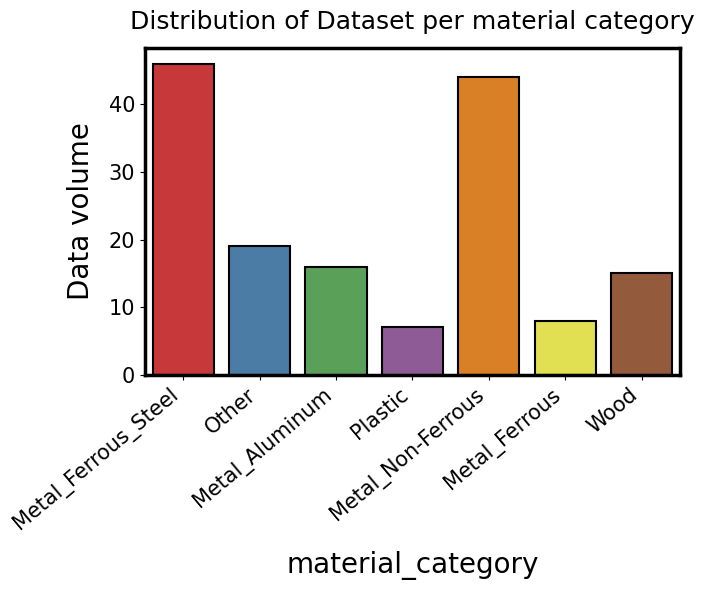

In [68]:
plot_data_distribution(consolidated_test_dataset, 'material_category', 
                       'Distribution of Dataset per material category', 'material_category_distrubution (test)')

Saving figure industries_distribution (test).png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


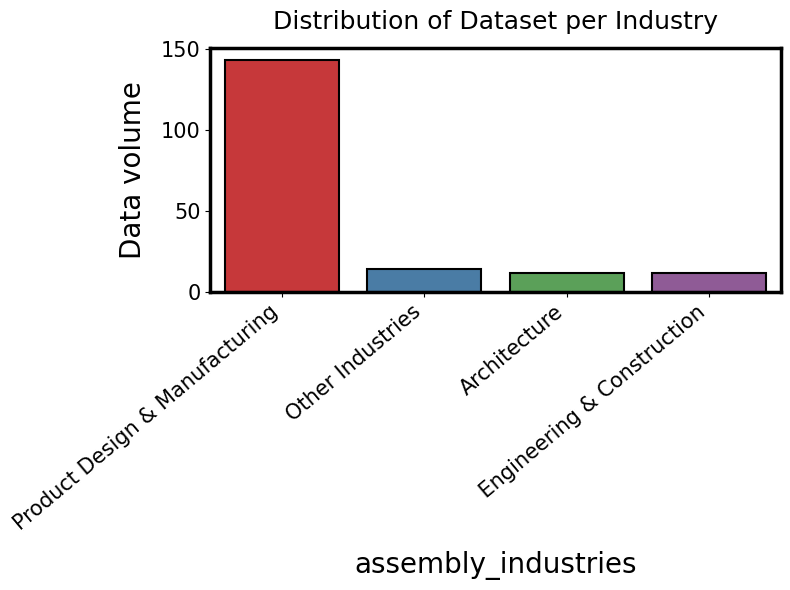

In [70]:
plot_multi_label_distribution(consolidated_test_dataset, 'assembly_industries', 
                              'Distribution of Dataset per Industry', 'industries_distribution (test)', figure_size = (8,6))

Saving figure Category Distrubution (test).png


C:\Users\Asus\AppData\Local\Temp\ipykernel_11864\3715853514.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


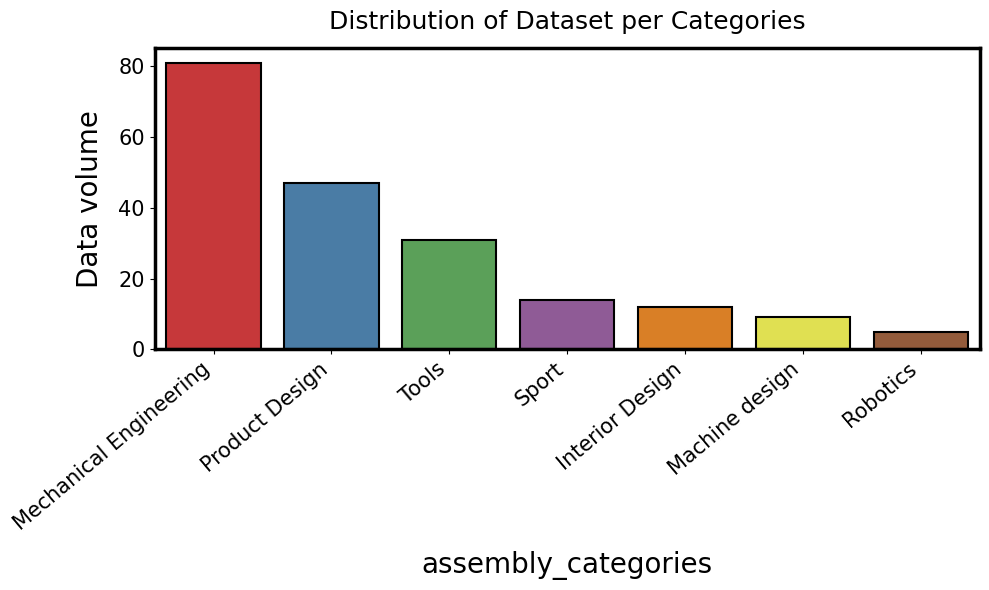

In [66]:
plot_multi_label_distribution_selected(consolidated_test_dataset, 'assembly_categories', 
                              'Distribution of Dataset per Categories', 'Category Distrubution (test)', 
                            figure_size = (10,6), top_n=20)

### Save the consolidated dataset

In [61]:
consolidated_test_dataset.to_csv(os.path.join(Feature_PATH, "consolidated_test_dataset_v4.csv"), index=False)

In [82]:
# Apply the transformations
transformed_test_dataset, encoder_test, one_hot_columns_test = transform_features(consolidated_test_dataset)
# Drop one of the redundant 'Architecture' columns
transformed_test_dataset_cleaned = transformed_test_dataset.drop(columns=['Architecture'])
transformed_test_dataset_cleaned

uuid  com_distance  center_of_mass_x  \
0    bbdf29da-060c-11ec-a52a-02ef91e90f5f     18.789386     -3.018946e-11   
1    bbdf9f22-060c-11ec-ac81-02ef91e90f5f     17.384202      1.921808e+00   
2    bbe89f86-060c-11ec-8111-02ef91e90f5f     15.731161      3.467308e+00   
3    bbee1dec-060c-11ec-aabe-02ef91e90f5f     13.623338      5.457923e+00   
4    bbee44f6-060c-11ec-bd48-02ef91e90f5f     10.639008      1.037246e+01   
..                                    ...           ...               ...   
150  3b4ce74c-05cc-11ec-a9ce-064a63348d37     66.832452      2.540000e+00   
151  3b4d0e4c-05cc-11ec-9c6d-064a63348d37     66.832452      1.025400e+02   
152  3b4d355a-05cc-11ec-9f42-064a63348d37     66.832452      1.025400e+02   
153  3b4d8388-05cc-11ec-acde-064a63348d37     66.832452      2.540000e+00   
154  3b4daaa2-05cc-11ec-bc9f-064a63348d37     14.015055      5.254000e+01   

     center_of_mass_y  center_of_mass_z     body_area   body_volume  \
0       -1.019470e-16          0.872410      7.679887      1.089020   
1       -6.312883e-01         -1.718481    972.513358    475.446755   
2        2.811920e+00          6.277969    460.819725    241.470603   
3       -1.478449e+00          0.795617     73.200000     21.600000   
4       -1.650000e+00         -3.440546     54.622106     11.563476   
..                ...               ...           ...           ...   
150      4.000000e+01          2.540000   1677.212800   2064.512000   
151      4.000000e+01         72.540000   1677.212800   2064.512000   
152      4.000000e+01          2.540000   1677.212800   2064.512000   
153      4.000000e+01         72.540000   1677.212800   2064.512000   
154      8.124696e+01         37.540000  27786.304206  33436.374783   

       material_category  volume_fraction  bounding_box_max_x  ...  \
0    Metal_Ferrous_Steel         0.000889               72.50  ...   
1                  Other         0.387934               72.50  ...   
2                  Other         0.197025               72.50  ...   
3    Metal_Ferrous_Steel         0.017624               72.50  ...   
4                  Other         0.009435               72.50  ...   
..                   ...              ...                 ...  ...   
150                 Wood         0.035476              127.54  ...   
151                 Wood         0.035476              127.54  ...   
152                 Wood         0.035476              127.54  ...   
153                 Wood         0.035476              127.54  ...   
154                 Wood         0.574567              127.54  ...   

     Interior Design  Machine design  Mechanical Engineering  Product Design  \
0                  0               1                       1               0   
1                  0               1                       1               0   
2                  0               1                       1               0   
3                  0               1                       1               0   
4                  0               1                       1               0   
..               ...             ...                     ...             ...   
150                0               0                       0               1   
151                0               0                       0               1   
152                0               0                       0               1   
153                0               0                       0               1   
154                0               0                       0               1   

     Robotics  Sport  Tools  Engineering & Construction  Other Industries  \
0           0      0      1                           0                 0   
1           0      0      1                           0                 0   
2           0      0      1                           0                 0   
3           0      0      1                           0                 0   
4           0      0      1                           0                 

In [83]:
transformed_test_dataset_cleaned.columns

Index(['uuid', 'com_distance', 'center_of_mass_x', 'center_of_mass_y',
       'center_of_mass_z', 'body_area', 'body_volume', 'material_category',
       'volume_fraction', 'bounding_box_max_x',
       ...
       'Interior Design', 'Machine design', 'Mechanical Engineering',
       'Product Design', 'Robotics', 'Sport', 'Tools',
       'Engineering & Construction', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object', length=122)

### Save the transformed dataset

In [84]:
column_name = "Wood"
if column_name in transformed_test_dataset_cleaned.columns:
    print(f"'{column_name}' is in the DataFrame.")
else:
    print(f"'{column_name}' is not in the DataFrame.")

'Wood' is in the DataFrame.


In [85]:
material_list = ['Metal_Non-Ferrous',
                 'Metal_Ferrous',
                 'Plastic',
                 'Other',
                 'Metal_Ferrous_Steel',
                 'Metal_Aluminum',
                 'Wood']

In [87]:
transformed_test_dataset_cleaned_save = transformed_test_dataset_cleaned.drop(columns=material_list)

In [88]:
# Assuming you've already transformed the training data and stored it in 'transformed_train_dataset'
train_columns = transformed_dataset_cleaned_save.columns

def standardize_test_features(transformed_test_dataset, train_columns):
    # Add missing columns to the test set and fill with 0s
    for col in train_columns:
        if col not in transformed_test_dataset.columns:
            transformed_test_dataset[col] = 0

    # Ensure the order of columns in the test set matches the training set
    transformed_test_dataset = transformed_test_dataset[train_columns]

    return transformed_test_dataset

# After transforming the test data, standardize its features
transformed_test_dataset_final = standardize_test_features(transformed_test_dataset_cleaned_save, train_columns)

In [89]:
transformed_test_dataset_final

uuid  com_distance  center_of_mass_x  \
0    bbdf29da-060c-11ec-a52a-02ef91e90f5f     18.789386     -3.018946e-11   
1    bbdf9f22-060c-11ec-ac81-02ef91e90f5f     17.384202      1.921808e+00   
2    bbe89f86-060c-11ec-8111-02ef91e90f5f     15.731161      3.467308e+00   
3    bbee1dec-060c-11ec-aabe-02ef91e90f5f     13.623338      5.457923e+00   
4    bbee44f6-060c-11ec-bd48-02ef91e90f5f     10.639008      1.037246e+01   
..                                    ...           ...               ...   
150  3b4ce74c-05cc-11ec-a9ce-064a63348d37     66.832452      2.540000e+00   
151  3b4d0e4c-05cc-11ec-9c6d-064a63348d37     66.832452      1.025400e+02   
152  3b4d355a-05cc-11ec-9f42-064a63348d37     66.832452      1.025400e+02   
153  3b4d8388-05cc-11ec-acde-064a63348d37     66.832452      2.540000e+00   
154  3b4daaa2-05cc-11ec-bc9f-064a63348d37     14.015055      5.254000e+01   

     center_of_mass_y  center_of_mass_z     body_area   body_volume  \
0       -1.019470e-16          0.872410      7.679887      1.089020   
1       -6.312883e-01         -1.718481    972.513358    475.446755   
2        2.811920e+00          6.277969    460.819725    241.470603   
3       -1.478449e+00          0.795617     73.200000     21.600000   
4       -1.650000e+00         -3.440546     54.622106     11.563476   
..                ...               ...           ...           ...   
150      4.000000e+01          2.540000   1677.212800   2064.512000   
151      4.000000e+01         72.540000   1677.212800   2064.512000   
152      4.000000e+01          2.540000   1677.212800   2064.512000   
153      4.000000e+01         72.540000   1677.212800   2064.512000   
154      8.124696e+01         37.540000  27786.304206  33436.374783   

       material_category  volume_fraction  bounding_box_max_x  ...  Toys  \
0    Metal_Ferrous_Steel         0.000889               72.50  ...     0   
1                  Other         0.387934               72.50  ...     0   
2                  Other         0.197025               72.50  ...     0   
3    Metal_Ferrous_Steel         0.017624               72.50  ...     0   
4                  Other         0.009435               72.50  ...     0   
..                   ...              ...                 ...  ...   ...   
150                 Wood         0.035476              127.54  ...     0   
151                 Wood         0.035476              127.54  ...     0   
152                 Wood         0.035476              127.54  ...     0   
153                 Wood         0.035476              127.54  ...     0   
154                 Wood         0.574567              127.54  ...     0   

     Utilities & Telecom  Virtual Reality  Water & Wastewater  Wood Working  \
0                      0                0                   0             0   
1                      0                0                   0             0   
2                      0                0                   0             0   
3                      0                0                   0             0   
4                      0                0                   0             0   
..                   ...              ...                 ...           ...   
150                    0                0                   0             0   
151                    0                0                   0             0   
152                    0                0                   0             0   
153                    0                0                   0             0   
154                    0                0                   0             0   

     Civil Infrastructure  Engineering & Construction  Media & Entertainment  \
0                       0                           0                      0   
1                       0                           0                      0   
2                       0                           0                      0   
3                       0                           0                      0 

In [90]:
%store encoder_test
%store transformed_test_dataset_final

Stored 'encoder_test' (LabelEncoder)
Stored 'transformed_test_dataset_final' (DataFrame)


In [91]:
nan_cols = transformed_test_dataset_final.columns[transformed_test_dataset_cleaned_save.isna().any()].tolist()
print(nan_cols)

[]


In [96]:
transformed_test_dataset_final.to_csv(os.path.join(Feature_PATH, "test_feature_transformed_cleaned_v4.csv"), index=False)

In [94]:
# List of all material categories
df_test_transformed_X = transformed_test_dataset_final.drop(columns=['material_category', 'uuid'])
df_test_transformed_X_cleaned = df_test_transformed_X.fillna(df_test_transformed_X.median())

In [95]:
df_test_transformed_X_cleaned.columns[df_test_transformed_X_cleaned.isna().any()].tolist()

[]